# CHAPTER 36: Variational Inference

### This code generates figures 2, 3, 4, 5, 6, 7, 8, and 9 from Chapter 36: Variational Inference (vol II)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Eduardo Faria Cabrera

required libraries:
    
1. numpy
2. matplotlib
3. scipy
4. warnings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from functions import scalar_gaussian, dirichlet, beta, mode_beta
from scipy.stats import norm
from scipy.special import digamma

import warnings
warnings.filterwarnings('ignore')

## Example 36.1 (Difficulty in evaluating the evidence -- I)

We consider a generative model for the observations $\boldsymbol{y}$ in the form of a $\textit{Bayesian}$ mixture of Gaussian models. Specifically, we let $(\mu_1,\mu_2)$ denote two mean parameters that are selected independently from two separate Gaussian distributions  with means $(\bar{\mu}_1,\bar{\mu}_2)$ and variances $(\sigma_{1}^2,\sigma_2^2)$, i.e., 

$$
\boldsymbol{\mu}_1\sim {\cal N}_{{\mu}_1}(\bar{\mu}_1,\sigma_{1}^2),\;\;\;\;\;\boldsymbol{\mu}_2\sim {\cal N}_{{\mu}_2}(\bar{\mu}_2,\sigma_{2}^2) \tag{36.2}
$$

We also let $\boldsymbol{k}$ denote a Bernoulli variable that assumes the values $k\in\{1,2\}$ with probabilities: 

$$
\mathbb{P}(\boldsymbol{k}=1)=p,\;\;\;\;\mathbb{P}(\boldsymbol{k}=2)=1-p,\;\;p>0 \tag{36.3}
$$

Since $\boldsymbol{k}$ assumes the values $\{1,2\}$ rather than the usual values $\{0,1\}$ for Bernoulli variables, its probability density function (pdf) is given by 

$$
f_{k}(k)=p^{2-k}(1-p)^{k-1}\overset{\Delta}{=} \textnormal{Bernoulli}(p) \tag{36.4}
$$

The model for generating the observation $\boldsymbol{y}$ is  the following (see Fig. 36.1):

$$
\left\{ \begin{array}{ll}
        \textbf{(generative model)} \\
        \textnormal{generate two random means} \boldsymbol{\mu}_1\sim {\cal N}_{{\mu}_1}(\bar{\mu}_1,\sigma_{1}^2) \textnormal{and} \boldsymbol{\mu}_2\sim {\cal N}_{{\mu}_2}(\bar{\mu}_2,\sigma_{2}^2) \\
        \textnormal{select a model index } \boldsymbol{k} \in {1, 2} \textnormal{ according to Bernoulli(p)} \\
        \textnormal{generate the observation } \boldsymbol{y}\sim {\cal N}_{y}(\mu_{\boldsymbol{k}},\sigma_{y,\boldsymbol{k}}^2)
\end{array} \right. \tag{36.5}
$$

where the variance of $\boldsymbol{y}$ is also dependent on the index $\boldsymbol{k}$; it is either $\sigma_{y,1}^2$ when $\boldsymbol{k}=1$ or $\sigma_{y,2}^2$ when $\boldsymbol{k}=2$. The values $(\sigma_{y,1}^2,\sigma_{y,2}^2)$ are known. In this way, the variance of $\boldsymbol{y}$, denoted by $\boldsymbol{\sigma}_{y}^2$, is itself another Bernoulli random variable with

$$
\mathbb{P}(\boldsymbol{\sigma}_y^2=\sigma_{y,1}^2)=p,\;\;\;\;
\mathbb{P}(\boldsymbol{\sigma}_y^2=\sigma_{y,2}^2)=1-p \tag{36.6}
$$

The main difference in model (36.5) in relation to the Gaussian mixture models considered earlier in Chapter 32 is that we are now allowing the parameters $(\boldsymbol{\mu}_1,\boldsymbol{\mu}_2)$ to be random variables with Gaussian priors of their own; thus, each realization for $y$ would arise from some random choice for $(\mu_1,\mu_2)$. As a result, the model now involves three latent variables, denoted by $\boldsymbol{z}=(\boldsymbol{k},\boldsymbol{\mu}_1,\boldsymbol{\mu}_2)$; one of the variables is discrete while the other two are continuous. The variable $\boldsymbol{\sigma}_y^2$ is attached to $\boldsymbol{k}$; once the value of $\boldsymbol{k}$ is known then the value of $\boldsymbol{\sigma}_y^2$ is also known. For this reason, we do not include $\boldsymbol{\sigma}_y^2$ in the list of latent variables.  There are many examples that fit into this mixture model. For instance, let $\boldsymbol{y}$ refer to the systolic blood pressure measure of an individual, assumed to be Gaussian distributed. Its mean value can be dependent on whether the patient has a particular medical condition (model $1$) or not (model $2$).


Now, according to the Bayes rule (3.39), if we were to determine the conditional pdf of the latent variables given the observation (i.e., the posterior), we would need to evaluate the ratio:

$$
f_{k,{\mu}_1,{\mu}_2|y}(k,\mu_1,\mu_2|y)=\frac{f_{y,k,{\mu}_1,{\mu}_2}(y,k,\mu_1,\mu_2)}{f_{y}(y)} \tag{36.7}
$$

The numerator is easy to compute due to independence since, assuming the parameters  $(\sigma_{y,1}^2,\sigma_{y,2}^2,\sigma_1^2,\sigma_2^2)$ and $(\bar{\mu}_1,\bar{\mu}_2,p)$ are known: 

$$
\begin{align*}
&f_{y,k,{\mu}_1,{\mu}_2}(y,k,\mu_1,\mu_2)\\
&=f_{{\mu}_1}(\mu_1)\times
f_{{\mu}_2}(\mu_2)\times f_{k}(k)\times f_{y|k,{\mu}_1,{\mu}_2}(y|k,\mu_1,\mu_2)\\
&={\cal N}_{\mu_1}(\bar{\mu}_1,\sigma_{1}^2)\times {\cal N}_{\mu_2}(\bar{\mu}_2,\sigma_{2}^2) \times p^{2-k}(1-p)^{k-1}\times {\cal N}_{y}(\mu_k,\sigma_{y,k}^2)
\end{align*} \tag{36.8}
$$

The difficulty in (36.7) lies in computing the evidence $f_{y}(y)$, which appears in the denominator, since it involves marginalizing (36.8) over the variables $\{k,{\mu}_1,{\mu}_2\}$ to get:

$$
\begin{align*}
&f_{y}(y)\\&=\int_{\mu_1,\mu_2}\left(\sum_{k=1}^2 f_{y,k,{\mu}_1,{\mu}_2}(y,k,\mu_1,\mu_2)\right) d\mu_1 d\mu_2 \\
&=\int_{\mu_1,\mu_2}\left(\sum_{k=1}^2
{\cal N}_{\mu_1}(\bar{\mu}_1,\sigma_{1}^2)\times {\cal N}_{\mu_2}(\bar{\mu}_2,\sigma_{\mu}^2) \times p^{2-k}(1-p)^{k-1}\times {\cal N}_{y}(\mu_k,\sigma_{y,k}^2) 
\right) d\mu_1 d\mu_2 \\
&=p\,\int_{\mu_1,\mu_2} {\cal N}_{\mu_1}(\bar{\mu}_1,\sigma_{1}^2)\times {\cal N}_{\mu_2}(\bar{\mu}_2,\sigma_{2}^2) \times {\cal N}_{y}(\mu_1,\sigma_{y,1}^2) 
d\mu_1 d\mu_2 \\
&+(1-p)\int_{\mu_1,\mu_2}{\cal N}_{\mu_1}(\bar{\mu}_1,\sigma_{1}^2)\times {\cal N}_{\mu_2}(\bar{\mu}_2,\sigma_{2}^2) \times {\cal N}_{y}(\mu_2,\sigma_{y,2}^2) 
d\mu_1 d\mu_2 \\
&=p\,\int_{\mu_1} {\cal N}_{\mu_1}(\bar{\mu}_1,\sigma_{1}^2)\times {\cal N}_{y}(\mu_1,\sigma_{y,1}^2) 
d\mu_1 \\
&+(1-p)\int_{\mu_2}{\cal N}_{\mu_2}(\bar{\mu}_2,\sigma_{2}^2) \times {\cal N}_{y}(\mu_2,\sigma_{y,2}^2) 
d\mu_2
\end{align*} \tag{36.9}
$$

That is, 

$$
\begin{align*}
f_{y}(y)=\frac{p}{2\pi (\sigma_1^2 \sigma_{y,1}^2)^{1/2}}\,\underbrace{\int_{\mu_1} e^{-\frac{1}{2}\Bigl(\frac{(\mu_1-\bar{\mu}_1)^2}{\sigma_{1}^2}+\frac{(y-\mu_1)^2}{\sigma_{y,1}^2}
\Bigr)}
d\mu_1}_{\overset{\Delta}{=} A}\,+\, \\
\frac{(1-p)}{2\pi (\sigma_2^2\sigma_{y,2})^{1/2}}\,
\underbrace{\int_{\mu_2} e^{-\frac{1}{2}\Bigl(
\frac{(\mu_2-\bar{\mu}_2)^2}{\sigma_{2}^2}+\frac{(y-\mu_2)^2}{\sigma_{y,2}^2}
\Bigr)}
d\mu_2}_{\overset{\Delta}{=} B}
\end{align*} \tag{36.10}
$$

Each of the last two integrals can be evaluated in closed form for this example. This is not generally the case for other generative models and/or probability distributions. Even when the evaluation is possible, it can still be tedious, as illustrated by continuing with the calculations in this case.  

We consider one of the integrals and the same derivation will apply to the other integral. Consider the exponent that appears in the exponential for the term designated by $A$. Introduce, for convenience, the centered variables

$
\mu_c\overset{\Delta}{=} \mu_1-\bar{\mu}_1,\;\;\;\;y_c\overset{\Delta}{=} y-\bar{\mu}_1
$

and note that

$$
\begin{align*} 
-\frac{1}{2}\left(\frac{(\mu_1-\bar{\mu}_1)^2}{\sigma_{1}^2}+\frac{(y-\mu_1)^2}{\sigma_{y,1}^2}
\right)&=
-\frac{1}{2}\left(\frac{\mu_c^2}{\sigma_{1}^2}+\frac{(y_c-\mu_c)^2}{\sigma_{y,1}^2}
\right) \\ &
=-\frac{1}{2\sigma_{1}^2}\left(\mu_c^2+\frac{\sigma_{1}^2}{\sigma_{y,1}^2}
(y_c-\mu_c)^2\right) \\ &
=-\frac{1}{2\sigma_{1}^2}\Bigl(\mu_c^2+\frac{\sigma_{1}^2}{\sigma_{y,1}^2}
(\mu_c^2+y_c^2-2\mu_c y_c)\Bigr) \\ &
=-\frac{1}{2\sigma_{1}^2}\Bigl[\Bigl(1+\frac{\sigma_{1}^2}{\sigma_{y,1}^2}\Bigr)\mu_c^2+\frac{\sigma_{1}^2}{\sigma_{y,1}^2}y_c^2-\frac{2\sigma_{1}^2}{\sigma_{y,1}^2}\mu_c y_c\Bigr] \\ &
\overset{(a)}{=}
-\frac{b}{2\sigma_{1}^2}\Bigl(\mu_c^2+\frac{1}{b}\frac{\sigma_{1}^2}{\sigma_{y,1}^2} y_c^2-\frac{2}{b}\frac{\sigma_{1}^2}{\sigma_{y,1}^2}\mu_c y_c\Bigr) \\ &
=-\frac{b}{2\sigma_{1}^2}\left[\Bigl(\mu_c-\frac{1}{b}\frac{\sigma_{1}^2}{\sigma_{y,1}^2} y_c\Bigr)^2+\Bigl(\frac{1}{b}\frac{\sigma_{1}^2}{\sigma_{y,1}^2} -\frac{1}{b^2}
\frac{\sigma_{1}^4}{\sigma_{y,1}^4}\Bigr) y_c^2\right]
\end{align*} \tag{36.12}
$$

where in step $(a)$ we introduced

$$
b\overset{\Delta}{=} 1+\frac{\sigma_{1}^2}{\sigma_{y,1}^2}\;=\;\frac{\sigma_{y,1}^2+\sigma_{1}^2}{\sigma_{y,1}^2} \tag{36.13}
$$

Let $\sigma_{H,1}^2$ denote the harmonic mean of $\sigma_{1}^2$ and $\sigma_{y,1}^2$, i.e.,

$$
\sigma_{H,1}^2\overset{\Delta}{=} \frac{2}{(1/\sigma_{1}^2) + (1/\sigma_{y,1}^2)} \tag{36.14}
$$

Then, some algebra shows that (36.12) simplifies to

$$
-\frac{1}{2}\Bigl(\frac{\mu_c^2}{\sigma_{1}^2}+\frac{(y_c-\mu_c)^2}{\sigma_{y,1}^2}\Bigr)
=-\frac{1}{\sigma_{H,1}^2}\Bigl(\mu_c-\frac{\sigma_{1}^2}
{\sigma_{y,1}^2+\sigma_{1}^2} y_c\Bigr)^2-
\frac{1}{2}\frac{1}{\sigma_{y,1}^2+\sigma_{1}^2}y_c^2 \tag{36.15}
$$

and, consequently, the term designated by the letter $A$ in (36.10) evaluates to 

$$
\begin{align*}
A&\overset{\Delta}{=} \int_{\mu_1}
e^{-\frac{1}{2}\left\{\frac{1}{\sigma_{H,1}^2/2}\Bigl(\mu_c-\frac{\sigma_{1}^2}{\sigma_{y,1}^2+\sigma_{1}^2} y_c\Bigr)^2-\frac{1}{\sigma_{y,1}^2+\sigma_{1}^2}y_c^2
\right\}}d\mu_1 \\ &
\overset{(b)}{=}
e^{-\frac{1}{2}\frac{1}{\sigma_{y,1}^2+\sigma_{1}^2}y_c^2}\times \sqrt{2\pi \sigma_{H,1}^2/2}
\,\underbrace{\int_{\mu_1}
\frac{1}{\sqrt{2\pi \sigma_{H,1}^2/2}}
e^{-\frac{1}{2}\frac{1}{\sigma_{H,1}^2/2}\Bigl(\mu_c-\frac{\sigma_{1}^2}{\sigma_{y,1}^2+\sigma_{1}^2} y_c\Bigr)^2d\mu_1}}_{=1} \\ &
= \sqrt{\pi \sigma_{H,1}^2}\,
\textnormal{exp}\left\{-\frac{1}{2}\frac{1}{\sigma_{y,1}^2+\sigma_{1}^2}(y-\bar{\mu}_1)^2\right\}
\end{align*} \tag{36.16}
$$

where the integral in step $(b)$ evaluates to 1 because it integrates a Gaussian pdf over the entire range of $\mu_1$ (or, equivalently, $\mu_c$). A similar  argument will show that the term $B$  in (36.10) evaluates to

$$
B
= \sqrt{\pi \sigma_{H,2}^2}\,
\textnormal{exp}\left\{-\frac{1}{2}\frac{1}{\sigma_{y,2}^2+\sigma_{2}^2}(y-\bar{\mu}_2)^2\right\} \tag{36.17}
$$

where

$$
\sigma_{H,2}^2\overset{\Delta}{=} \frac{2}{(1/\sigma_{2}^2) + (1/\sigma_{y,2}^2)} \tag{36.18}
$$

Combining the results, some algebra leads to 

$$
\;f_{y}(y)=p\,{\cal N}_{y}(\bar{\mu}_1, \sigma_{1}^2+\sigma_{y,1}^2)\;+\;(1-p)\,{\cal N}(\bar{\mu}_2, \sigma_2^2+\sigma_{y,2}^2)\; \tag{36.19}
$$

In other words, the evidence has the form of a Gaussian mixture model; it is a combination of two Gaussian distributions with means $(\bar{\mu}_1,\bar{\mu}_2)$ and variances $(\sigma_1^2+\sigma_{y,1}^2, \sigma_2^2+\sigma_{y,2}^2)$.

Figure 36.2 simulates this calculation for two situations. In the first case, we set $\sigma_{1}^2=2, \sigma_{2}^2=10, \sigma_{y,1}^2=1, \sigma_{y,2}^2=3,$ $\bar{\mu}_1=3$, $\bar{\mu}_2=15$, and $p=0.3$. We generate $N=10,000$ realizations $\{y_n\}$. For each realization: (a) we generate two random means $\mu_1$ and $\mu_2$ from the Gaussian distributions ${\cal N}_{\mu_1}(3,2)$ and ${\cal N}_{\mu_2}(15,10)$; (b) we pick an index $k\in\{1,2\}$ according to Bernoulli$(p)$; (c) and generate $y_n$ from ${\cal N}_{y}(\mu_k,\sigma_{y,k})$. The figure shows a normalized histogram for the $10,000$ realizations along with the (smooth) curve corresponding to the evidence (36.19). There are 2937 samples under model $k=1$ and 7063 samples under model $k=2$.

In [23]:
K = 2 # two Gaussian components
mu_bar1 = 3 # mean for mu1
mu_bar2 = 15 # mean for mu2
sigma_1 = 2 # variance of distribution for mu1
sigma_2 = 10 # variance of distribution for mu2
sigma_y1 = 1 # variance of observations y under model 1
sigma_y2 = 3 # variance of observations y under model 2
p = 0.3 # probability of generating data from model 1

N = 10000 # once the means have been generated, we generate this many observations
y = np.zeros(N)

j1 = 0 # index for measurements from distribution with mean mu1
j2 = 0 # index for measurements from distribution with mean mu2

y1 = np.zeros(N)
y2 = np.zeros(N)
model = np.zeros(N)
mean_value = np.zeros((N, 2))

for n in range(N):
    mu1 = np.sqrt(sigma_1)*np.random.randn() # generate random mean mu1 for each sample
    mu1 = mu1 + mu_bar1
    mu2 = np.sqrt(sigma_2)*np.random.randn() # generate random mean mu2 for each sample
    mu2 = mu2 + mu_bar2

    x = np.random.rand()
    if x <= p: #model 1
        mu = mu1
        j1 = j1+1
        y1[j1] = np.sqrt(sigma_y1)*np.random.randn()
        y1[j1] = y1[j1] + mu
        y[n] = y1[j1]
        model[n] = 1
    else: # model 2
        mu = mu2
        j2 = j2+1
        y2[j2] = np.sqrt(sigma_y2)*np.random.randn()
        y2[j2] = y2[j2] + mu
        y[n] = y2[j2]
        model[n] = 2
    mean_value[n, :] = np.array([mu1, mu2]) # saves the models generated for n-th observation
                                            # to compute resposibility later

error = 0
prob_estimated = np.zeros(N)
model_estimated = np.zeros(N)

for n in range(N): # computing the likelihood of belonging to model k = 1 for each realization
    value1 = scalar_gaussian(y[n], mean_value[n, 0], sigma_y1)
    value2 = scalar_gaussian(y[n], mean_value[n, 1], sigma_y2)
    prob_estimated[n] = (p*value1)/(p*value1 + (1-p)*value2) # probability of belonging to model 1

    if prob_estimated[n] >= 0.5:
        model_estimated[n] = 1
    else:
        model_estimated[n] = 2
    if model_estimated[n] != model[n]:
        error += 1

T = int(max(y)+2)
f = np.array([])

for t in np.arange(-T, T, 0.01):
    f1 = scalar_gaussian(t, mu_bar1, sigma_y1+sigma_1)
    f2 = scalar_gaussian(t, mu_bar2, sigma_y2+sigma_2)
    f = np.append(f, p*f1 + (1-p)*f2)

print("error in assigning correct model", (error/N)*100)
print("total samples plus number of samples from models 1 and 2", N, j1, j2)

error in assigning correct model 0.24
total samples plus number of samples from models 1 and 2 10000 3106 6894


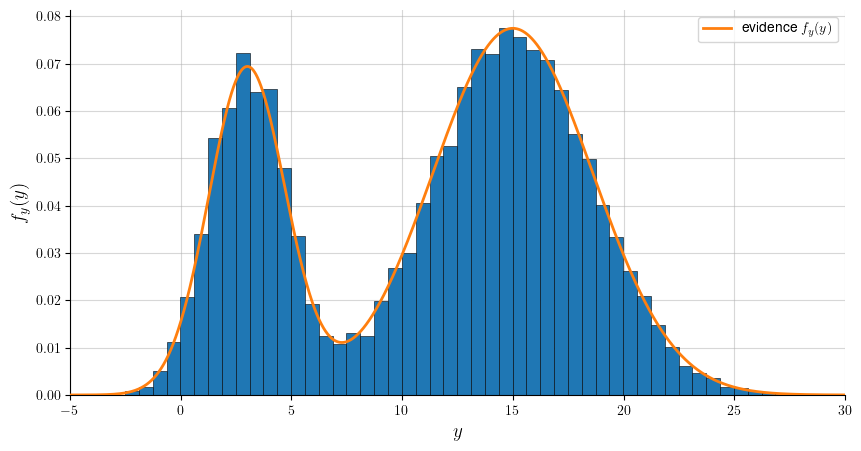

In [24]:
#figure 2 (evaluating evidence)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 5
fig = plt.figure()

ax = fig.add_subplot(111)
ax.hist(y, bins=50, density=True, zorder=2, edgecolor="black", linewidth=0.4)
ax.plot(np.arange(-T, T, 0.01), f, linewidth=2, label="evidence $f_y(y)$", zorder=3)
ax.set_xlabel("$y$", fontsize=14)
ax.set_ylabel("$f_y(y)$", fontsize=14)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim([-5, 30])
plt.grid(zorder=0, alpha=0.5)
plt.legend()

plt.show()

**Figure 36.2** Normalized histogram of $N=10,000$ realizations $\{y_n\}$  generated according to the Bayesian mixture model with $\sigma_{1}^2=2,  \sigma_{2}^2=10$, $\sigma_{y,1}^2=1, \sigma_{y,2}^2=3$, $\bar{\mu}_1=3$, $\bar{\mu}_2=15$, and $p=0.3$. The solid curve plots the resulting evidence from (36.19).

Using expression (36.19) we can evaluate the conditional pdf $f_{k, {\mu}_1, {\mu}_2|y}(k,\mu_1,\mu_2|y)$, as well as other useful conditional pdfs. In particular, we can determine the responsibility for each model $\boldsymbol{k}$ in explaining the observation $\boldsymbol{y}$ as follows. Using the Bayes rule and the fact that $\boldsymbol{k}$ is independent of $ \boldsymbol{\mu}_1$ and $\boldsymbol{\mu}_2$ we have (we are dropping the subscripts from the pdf functions to simplify the notation):

$$
\begin{align*}
f(y,k|\mu_1,\mu_2) &=f_{y}(y|\mu_1,\mu_2)\, \mathbb{P}(\boldsymbol{k}=k|\boldsymbol{y}=y,\mu_1,\mu_2) \\ &
=f(y|\mu_1,\mu_2) \,\mathbb{P}(\boldsymbol{k}=k|\boldsymbol{y}=y) \\ &
=\mathbb{P}(\boldsymbol{k}=k|\mu_1,\mu_2)\,f(y|k,\mu_1,\mu_2) \\ &
=\mathbb{P}(\boldsymbol{k}=k)\,f(y|k,\mu_1,\mu_2) \tag{36.20}
\end{align*}
$$

and, hence, 

$$
\mathbb{P}(\boldsymbol{k}=1|\boldsymbol{y}=y) =\frac{\mathbb{P}(\boldsymbol{k}=1)\,f(y|\boldsymbol{k}=1,\mu_1,\mu_2)}{f(y|\mu_1,\mu_2)} \tag{36.21}
$$

That is, 

$$
\mathbb{P}(\boldsymbol{k}=1|\boldsymbol{y}=y) 
\;=\;
\frac{p\,{\cal N}_{y}(\mu_1,\sigma_{y,1}^2)}{p{\cal N}_{y}(\mu_1,\sigma_{y,1}^2)+(1-p){\cal N}(\mu_2,\sigma_{y,2}^2)} \tag{36.22}
$$

In this expression, the scalars $(\mu_1,\mu_2)$ correspond to the means used to generate the observation $y$. For the realizations used to generate Fig. 36.2, this calculation led to misclassification error on the order of $0.35\%$. 


It is not difficult to envision that slight variations in the generative model (36.5) can make the computation of the evidence $f_{y}(y)$ more demanding than what we have seen here, or even impossible to obtain in closed form. For example, what if the means $( {\mu}_1, {\mu}_2)$ are selected according to some non-Gaussian distribution? The calculations can quickly become more cumbersome.

## Example 36.3 (Gaussian mixture model)

We reconsider the generative model (36.5) and use it to generate $N$ independent observations, $\{y_n\}$, as follows:

$$
\left\{ \begin{array}{ll}
        \textnormal{generate two random means}  \boldsymbol{\mu}_1\sim {\cal N}_{ {\mu}_1}(\bar{\mu}_1,\sigma_{1}^2) \textnormal{and}  \boldsymbol{\mu}_2\sim {\cal N}_{ {\mu}_2}(\bar{\mu}_2,\sigma_{2}^2) \\
        \textbf{for each } \textnormal{n = 1, 2, ..., N:} \\
        \quad \textnormal{select a model index } \boldsymbol{k}_n \in {1, 2} \textnormal{ according to Bernoulli(p)} \\
        \quad \textnormal{generate the observation } \boldsymbol{y}_n\sim {\cal N}_{y}(\mu_{k},\sigma_{y,\boldsymbol{k}}^2) \\
        \textbf{end} 
\end{array} \right. \tag{36.45}
$$

That is, we associate a Bernoulli variable $k_n$, with subscript $n$, with each observation $y_n$ such that

$$
\begin{align*}
&\mathbb{P}(\boldsymbol{k}_{n}=1)=p> 0 \tag{36.46a}\\
&f_{k}(k_n)=p^{2-k_n}\,(1-p)^{k_n-1} \tag{36.46b}
\end{align*}
$$

where the second expression shows the form of the pdf for $\boldsymbol{k}_n$. We therefore end up with a collection of $N$ \textit{independent} variables $\{\boldsymbol{k}_n\}$. We will use the notation $\boldsymbol{y}_{1:N}$ and $\boldsymbol{k}_{1:N}$ to refer to the $N$ observations and their class variables. In Prob. 36.6 we extend the analysis to a case involving $K$ models rather than only two.

In this problem we have three latent variables, $( \boldsymbol{\mu}_1, \boldsymbol{\mu}_2,\boldsymbol{k}_{1:N})$. Since the value of $\boldsymbol{k}$ determines the variance of $\boldsymbol{y}$, either $\sigma_{y,1}^2$ or $\sigma_{y,2}^2$, we do not need to incorporate $\sigma_{y,\boldsymbol{k}}^2$ into the set of latent variables because it will be redundant information. The objective is to apply construction (36.42) to estimate the conditional pdf of the latent variables given the observations, namely, $f_{ {\mu}_1, {\mu}_2,k_{1:N}|y_{1:N}}(\mu_1,\mu_2,k_{1:N}|y_{1:N})$. 
 
We  denote the approximation for the posterior by $q_{ {\mu}_1, {\mu}_2,k_{1:N}}(\mu_1,\mu_2,k_{1:N})$ and assume it has the factored form:

$$
q_{ {\mu}_1, {\mu}_2,k_{1:N}}(\mu_1,\mu_2,k_{1:N})\;=\;q_{ {\mu}_1}(\mu_1)\,
q_{ {\mu}_2}(\mu_2)\,\prod_{n=1}^N q_{k_n}(k_n) \tag{36.47}
$$

It is worth noting that this ``mean-field approximation'' expression is  exact in this case since the variables $( \boldsymbol{\mu}_1, \boldsymbol{\mu}_2,\boldsymbol{k}_n)$ are independent of each other in the assumed generative model. The analysis will show that the factors $q_{ {\mu}_1}(\mu_1)$ and $q_{ {\mu}_2}(\mu_2)$ will be Gaussian. We will determine their means and variances. Likewise, the factor $q_{k_n}(k_n)$ will turn out to be Bernoulli and we will  determine its probability of success.

According to (36.42), the optimal factors should satisfy the following coupled equations (we drop the $\star$ superscript for convenience of notation):

$$
\begin{align*} &
\ln q_{ {\mu}_1}(\mu_1)=\mathbb{E}_{k_{1:N}, {\mu}_2}\,\Bigl(\ln f_{y_{1:N},k_{1:N}, {\mu}_1, {\mu_2}}(y_{1:N},k_{1:N},\mu_1,\mu_2)\Bigl) \tag{36.48a} \\ &
\ln q_{ {\mu}_2}(\mu_2)=\mathbb{E}_{k_{1:N}, {\mu}_1}\,\Bigl(\ln f_{y_{1:N},k_{1:N}, {\mu}_1, {\mu_2}}(y_{1:N},k_{1:N},\mu_1,\mu_2)\Bigl) \tag{36.48b}\\ &
\ln q_{k_n}(k_n)=\mathbb{E}_{k_{-n}, {\mu}_1, {\mu}_2}\,\Bigl(\ln f_{y_{1:N},k_{1:N}, {\mu}_1, {\mu_2}}(y_{1:N},k_{1:N},\mu_1,\mu_2)\Bigl) \tag{36.48c} \\ &
\textnormal{for}\;n=1,2,\ldots,N
\end{align*}
$$

where the notation $\mathbb{E}_{a}(\cdot)$ on the right-hand side refers to  expectation relative to the variational distribution of the random variable $\boldsymbol{a}$, i.e., relative to $q_{a}(a)$. To be more precise, we should have written $\mathbb{E}_{q_{a}}$ instead of $\mathbb{E}_{a}$. We continue with the compact notation. 
 
Let us first comment on the third equation (36.48c). This equation determines the variational factor for each class variable $\boldsymbol{k}_n\in\{1,2\}$. We know that $\boldsymbol{k}_n$ is discrete in nature and its {\em true} distribution has a Bernoulli form with probability of success $p$, as described in 
(36.46a)--(36.46b). We will therefore adopt a similar Bernoulli model for its variational factor, namely, we will assume that 

$$
q_{k_n}(k_n)= p_n^{\,2-k_n}(1- p_n\,)^{k_n-1},\;\;k_n\in\{1,2\},\;\; p_n\in[0,1] \tag{36.49}
$$

which depends on some unknown parameter $ p_n$ to be learned. The value for this parameter will follow from relation (36.48c), as we explain toward the end of this example. For now, we are only adopting a form for $q_{k_n}(k_n)$. This factor approximates the conditional pdf of $\boldsymbol{k}_n$ given all observations, $f_{k_n|y_{1:N}}(k_n|y_{1:N})$

We now determine the optimal variational factors from (36.48a)--(36.48c). To begin with, in a manner similar to  (36.8), we have

$$
\begin{align*}
&f_{y_{1:N},k_{1:N}, {\mu}_1, {\mu}_2}(y_{1:N},k_{1:N},\mu_1,\mu_2) \\ &
=f_{ {\mu}_1}(\mu_1)\times
f_{ {\mu}_2}(\mu_2)\times \left[\prod_{n=1}^{N} f_{k}(k_n)\times f_{y|k_n, {\mu}_1, {\mu}_2}(y_n|k_n,\mu_1,\mu_2)\right] \\ &
={\cal N}_{\mu_1}(\bar{\mu}_1,\sigma_{1}^2)\times {\cal N}_{\mu_2}(\bar{\mu}_2,\sigma_{2}^2) \times \left[\prod_{n=1}^N p^{2-k_n}(1-p)^{k_n-1}\times {\cal N}_{y_n}(\mu_{k_n},\sigma_{y,k_n}^2)\right] \tag{36.50}
\end{align*}
$$


so that the log-likelihood function is given by

$$
\begin{align*} &
\ln f_{y_{1:N},k_{1:N}, {\mu}_1, {\mu}_2}(y_{1:N},k_{1:N},\mu_1,\mu_2) \\ &
=\ln {\cal N}_{\mu_1}(\bar{\mu}_1,\sigma_{1}^2)+\ln {\cal N}_{\mu_2}(\bar{\mu}_2,\sigma_{2}^2) + \\ &
\quad \sum_{n=1}^N \left[\ln p^{2-k_n}(1-p)^{k_n-1}+\ln {\cal N}_{y_n}(\mu_{k_n},\sigma_{y,k_n}^2)\right] \\ &
=-\frac{1}{2\sigma_{1}^2}(\mu_1-\bar{\mu}_1)^2-\frac{1}{2\sigma_{2}^2}
(\mu_2-\bar{\mu}_2)^2+ \\ &
\quad\sum_{n=1}^N  \left[\ln\Bigl(p^{2-k_n}(1-p)^{k_n-1}\Bigr)
-\frac{1}{2\sigma_{y,k_n}^2}(y_n-\mu_{k_n})^2\right]+C \tag{36.51}
\end{align*}
$$

where we have grouped all terms that are independent of the latent variables into the constant $C$. We can use the above expansion to evaluate the  expectations that appear on the right-hand side of  (36.48a)--(36.48c). For example, refer to the first equality (36.48a). If we take expectations $\textit{relative to the variational distributions}$ of $\boldsymbol{k}_{1:N}$ and $ \boldsymbol{\mu}_2$, only two terms will remain that depend on $\mu_1$. We collect the other terms into a constant  that is independent of $\mu_1$ and write: 

$$
\begin{align*} &
\mathbb{E}_{k_{1:N}, {\mu}_2}\,\Bigl(\ln f_{y_{1:N},k_{1:N}, {\mu}_1, {\mu_2}}(y_{1:N},k_{1:N},\mu_1,\mu_2)\Bigr) \\ &
=-\frac{1}{2\sigma_{1}^2}(\mu_1-\bar{\mu}_1)^2 -\sum_{n=1}^N \mathbb{E}_{k_n, {\mu}_2}\Bigl(\frac{1}{2\sigma_{y,\boldsymbol{k}_n}^2}(\boldsymbol{y}_n- \boldsymbol{\mu}_{k_n})^2\Bigr)
+(\textnormal{cte independent of} \mu_1) \tag{36.52}
\end{align*}
$$


We can evaluate the second term on the right-hand side to find 

$$
\begin{align*} 
\mathbb{E}_{k_n, {\mu}_2}\left(\frac{1}{\sigma_{y,\boldsymbol{k}_n}^2}(\boldsymbol{y}_n- \boldsymbol{\mu}_{k_n})^2\right)& =\mathbb{E}_{ {\mu}_2}\left\{\mathbb{E}_{k_n}\left(\frac{1}{\sigma_{y,k_n}^2}
(y_n- {\mu}_{k_n})^2\right)\right\} \\ &
\overset{(a)}{=}
\mathbb{E}_{ {\mu}_2}\left\{ p_n\frac{1}{\sigma_{y,1}^2}(\boldsymbol{y}_n- \boldsymbol{\mu}_{1})^2+(1- p_n)\frac{1}{\sigma_{y,2}^2}
(\boldsymbol{y}- \boldsymbol{\mu}_{2})^2\right\} \\ &
= p_n\frac{1}{\sigma_{y,1}^2}(y_n-{\mu}_{1})^2\;+\;\textnormal{term independent of } \mu_1 \\ &
\overset{\Delta}{=}  p_n\frac{1}{\sigma_{y,1}^2}(y_{n,c}-{\mu}_{1,c})^2\;+\;\textnormal{term independent of } \mu_1
\end{align*} \tag{36.53}
$$

where in step $(a)$ we used the fact that the variational distribution for the latent variable $\boldsymbol{k}_n$ is Bernoulli with the probability of class $\boldsymbol{k}_n=1$ equal to $ p_n$.  And in the last step we introduced the centered variables

$$
\mu_{1,c}\overset{\Delta}{=} \mu_1-\bar{\mu}_1,\;\;\;\;\;y_{n,c}\overset{\Delta}{=} y_n-\bar{\mu}_1 \tag{36.54}
$$

Consequently, by letting $C'$ denote terms that are independent of $\mu_1$:

$$
\begin{align*} &
\mathbb{E}_{k_{1:N}, {\mu}_2}\,\Bigl(\ln f_{y_{1:N},k_{1:N}, {\mu}_1, {\mu_2}}(y_{1:N},k_{1:N},\mu_1,\mu_2)\Bigl) \\ &
=-\frac{1}{2\sigma_{1}^2}\mu_{1,c}^2 -\frac{1}{2\sigma_{y,1}^2}\sum_{n=1}^N \Bigl( p_{n} y_{n,c}^2+ p_n{\mu}_{1,c}^2-2 p_n\,y_{n,c} {\mu}_{1,c}\Bigr)
+C' \\ &
=\left(\frac{1}{\sigma_{y,1}^2}\sum_{n=1}^N  p_n y_{n,c}\right)\mu_{1,c} -\left(\frac{1}{2\sigma_{1}^2}+\frac{1}{2\sigma_{y,1}^2}\sum_{n=1}^N  p_n\right)\mu_{1,c}^2
+C'
\end{align*} \tag{36.55}
$$

Substituting into (36.48a) we obtain 

$$
q_{ {\mu}_1}(\mu_1)\propto \textnormal{exp}\left\{
\left(\frac{1}{\sigma_{y,1}^2}\sum_{n=1}^N  p_n y_{n,c}\right)\mu_{1,c} -\left(\frac{1}{2\sigma_{1}^2}+\frac{1}{2\sigma_{y,1}^2}\sum_{n=1}^N  p_n\right)\mu_{1,c}^2\right\} \tag{36.56}
$$ 

The expression on the right-hand side can be normalized to a Gaussian distribution over the centered variable $ \boldsymbol{\mu}_{1,c}$, with mean and variance denoted by  $\bar{\mu}_{q,1}$ and $\sigma_{q,1}^2$, respectively. To see this, we refer back to the analysis  from Chapter 5 showing how Gaussian distributions are special cases of the exponential family of distributions. If we refer to expression (5.11) we observe that the expression  on the right-hand side of (36.56) is written in a similar form with the corresponding sufficient statistics vector given by

$$
T(\mu_1) =
\begin{bmatrix}
\mu_{1, c} \\ \mu_{1, c}^{2}
\end{bmatrix} \tag{36.57}
$$

and with coefficient vector 

$$
\theta = 
\begin{bmatrix}
\dfrac{1}{\sigma_{y,1}^2}\displaystyle\sum_{n=1}^N  p_n y_{n,c} \\
-\dfrac{1}{2\sigma_{1}^2}-\dfrac{1}{2\sigma_{y,1}^2}\displaystyle\sum_{n=1}^N  p_n
\end{bmatrix} \tag{36.58}
$$

We  know from expression (5.13) that the entries of $\theta$ define the mean and variance of the distribution as follows:

$$
\theta = 
\begin{bmatrix}
\bar{\mu}_{q,1}/\sigma_{q,1}^2 \\
-1/2\sigma_{q,1}^2
\end{bmatrix} \tag{36.59}
$$

Therefore, we can determine $(\bar{\mu}_{q,1},\sigma_{q,1}^2)$  by solving

$$
\frac{\bar{\mu}_{q,1}}{\sigma_{q,1}^2}=\frac{1}{\sigma_{y,1}^2}\sum_{n=1}^N  p_n y_{n,c} \tag{36.60a}
$$

$$
-\frac{1}{2\sigma_{q,1}^2}=-\frac{1}{2\sigma_{1}^2}-\frac{1}{2\sigma_{y,1}^2}\sum_{n=1}^N  p_n \tag{36.60b}
$$

from which we conclude that 

$$
\bar{\mu}_{q,1}= \frac{\sum_{n=1}^N  p_n(y_{n}-\bar{\mu}_1)}{(\sigma_{y,1}^2/\sigma_{1}^2)+\sum_{n=1}^N p_n} \tag{36.61a}
$$

$$
\sigma_{q,1}^2 = \frac{\sigma_{y,1}^2}{(\sigma_{y,1}^2/\sigma_{1}^2)+\sum_{n=1}^N  p_n} \tag{36.61b}
$$

Observe in passing how the summation in the denominator of $\sigma_{q,1}^2$ grows with $N$ so that $\sigma_{q,1}^2\rightarrow 0$. Observe also that

$$
\frac{\bar{\mu}_{q,1}}{\sigma_{q,1}^2}= \frac{1}{\sigma_{y,1}^2}\sum_{n=1}^N  p_n(y_{n}-\bar{\mu}_1) \tag{36.62}
$$

The expression on the right-hand side of 
(36.56) can be normalized to the following Gaussian distribution over the random variable $ \boldsymbol{\mu}_{1,c}$:

$$
f_{ {\mu}_{1,c}}(\mu_{1,c})\overset{\Delta}{=} \frac{1}{\sqrt{2\pi\sigma_{q,1}^2}}\textnormal{exp}\left\{-\frac{1}{2\sigma_{q,1}^2}(\mu_{1,c}-\bar{\mu}_{q,1})^2\right\} \tag{36.63}
$$

That is, the distribution for $ \boldsymbol{\mu}_{1,c}$ is Gaussian, written as

$$
 \boldsymbol{\mu}_{1.c}\;\sim\;{\cal N}_{\mu_{1,c}}(\bar{\mu}_{q,1}, \sigma_{q,1}^2) \tag{36.64}
$$

from which we conclude that the distribution $q_{ {\mu}_1}(\mu_1)$ is also Gaussian with

$$
q_{ {\mu}_{1}}(\mu_{1})\;\sim\; {\cal N}_{\mu_1}\Bigl(\bar{\mu}_1 + \bar{\mu}_{q,1},\sigma_{q,1}^2\Bigr) \tag{36.65}
$$

where we added $\bar{\mu}_1$ to the mean value to undo the centering operation. The variance remains unchanged. Repeating the argument for the second equality (36.48b) we similarly conclude that $q_{ {\mu}_2}(\mu_2)$ is  Gaussian-distributed with:

$$
q_{ {\mu}_2}(\mu_2)\sim {\cal N}_{\mu_2}(\bar{\mu}_2+\bar{\mu}_{q,2},\sigma_{q,2}^2) \tag{36.66}
$$


where now

$$
\bar{\mu}_{q,2}= \frac{\sum_{n=1}^N (1- p_n)(y_{n,c}-\bar{\mu}_2)}{(\sigma_{y,2}^2/\sigma_{2}^2)+\sum_{n=1}^N(1- p_n)} \tag{36.66a}
$$

$$
\sigma_{q,2}^2 =\frac{\sigma_{y,2}^2}{(\sigma_{y,2}^2/\sigma_{2}^2)+\sum_{n=1}^N (1- p_n)} \tag{36.66b}
$$

Observe again that 
 
$$
\frac{\bar{\mu}_{q,2}}{\sigma_{q,2}^2}=-\frac{\bar{\mu}_2}{\sigma_{y,2}^2}\;+\;\sum_{n=1}^N (1- p_n)\frac{(y_n-\bar{\mu}_2)}{\sigma_{y,2}^2} \tag{36.68}
$$

Although we are able to deduce analytically the form of the  variational factors in this problem, this is not possible in general and we will need to resort to alternative iterative techniques to complete the arguments (as will be illustrated in subsequent sections). 
 
 
Finally, we turn to (36.48c) and the assumed Bernoulli form for $q_{k_n}(k_n)$ to deduce that it must hold (where terms that are independent of $\boldsymbol{k}_n$ are grouped into the constant):

$$
\begin{align*} 
\ln  p_n &=\mathbb{E}_{k_{-n}, {\mu}_1, {\mu}_2}\,\Bigl\{\ln f_{y_{1:N},k_{1:N}, {\mu}_1, {\mu_2}}(y_{1:N},k_{1:N},\mu_1,\mu_2)\,|\,\boldsymbol{k}_n=1\Bigr\} \\ &
\overset{(36.51)}{=}
-\frac{1}{2\sigma_{y,1}^2}\mathbb{E}_{ {\mu}_1}(y_n- \boldsymbol{\mu}_{1})^2+(\textnormal{constant}) \\ &
=-\frac{1}{2\sigma_{y,1}^2}\mathbb{E}_{ {\mu}_1}(y_n-\bar{\mu}_1+\bar{\mu}_1- \boldsymbol{\mu}_{1})^2+(\textnormal{constant}) \\ &
=\frac{1}{\sigma_{y,1}^2}(y_n-\bar{\mu}_1)\,\mathbb{E}_{ {\mu}_1 }( \boldsymbol{\mu}_1-\bar{\mu}_1)-\frac{1}{2\sigma_{y,1}^2}
\mathbb{E}_{ {\mu}_1 }( \boldsymbol{\mu}_1-\bar{\mu}_1)^2+(\textnormal{constant}) \\ &
=\frac{1}{\sigma_{y,1}^2}(y_n-\bar{\mu}_1)\bar{\mu}_{q,1}-
\frac{\sigma_{q,1}^2}{2\sigma_{y,1}^2}+(\textnormal{constant})
\end{align*} \tag{36.69}
$$

It follows that

$$
\ln  p_n\propto \frac{1}{\sigma_{y,1}^2}(y_n-\bar{\mu}_1)\bar{\mu}_{q,1}-
\frac{\sigma_{q,1}^2}{2\sigma_{y,1}^2}\overset{\Delta}{=} \ln (a_n) \tag{36.70}
$$

We could have alternatively expanded (36.69) in the following form:

$$
\begin{align*}
\ln  p_n & =
-\frac{1}{2\sigma_{y,1}^2}\mathbb{E}_{ {\mu}_1}(y_n- \boldsymbol{\mu}_{1})^2+(\textnormal{constant}) \\ &
=\frac{1}{\sigma_{y,1}^2}y_n \mathbb{E}_{ {\mu}_1}( \boldsymbol{\mu}_{1})
-\frac{1}{2\sigma_{y,1}^2}\mathbb{E}_{ {\mu}_1}( \boldsymbol{\mu}_1)^2+(\textnormal{constant}) \\ &
=\frac{1}{\sigma_{y,1}^2}y_n(\bar{\mu}_1+\bar{\mu}_{q,1})
-\frac{\sigma_{q,1}^2+(\bar{\mu}_1+\bar{\mu}_{q,1})^2}{2\sigma_{y,1}^2}+(\textnormal{constant})
\end{align*} \tag{36.71}
$$

so that we can also use the expression

$$
\ln  p_n\propto 
\frac{1}{\sigma_{y,1}^2}y_n(\bar{\mu}_1+\bar{\mu}_{q,1})
-\frac{1}{2\sigma_{y,1}^2}\Bigl(\sigma_{q,1}^2+(\bar{\mu}_1+\bar{\mu}_{q,1})^2\Bigr)\overset{\Delta}{=} \ln(a_n) \tag{36.72}
$$

We list this second expression to facilitate comparison with another derivation given later in our presentation. Likewise, we can derive either of the following expressions:

$$
\ln (1- p_n)\propto \frac{1}{\sigma_{y,2}^2}(y_n-\bar{\mu}_2)\bar{\mu}_{q,2}-
\frac{\sigma_{q,2}^2}{2\sigma_{y,2}^2}\overset{\Delta}{=} \ln (b_n) \tag{36.73}
$$

$$
\ln (1- p_n)\propto \frac{1}{\sigma_{y,2}^2}y_n(\bar{\mu}_2+\bar{\mu}_{q,2})
-\frac{1}{2\sigma_{y,2}^2}\Bigl(\sigma_{q,2}^2+(\bar{\mu}_2+\bar{\mu}_{q,2})^2\Bigr)\overset{\Delta}{=} \ln(b_n) \tag{36.74}
$$

Since the estimates $ p_n$ and $1- p_n$ must add up to 1, we can obtain true probability values by normalizing by the sum $a_n+b_n$, namely, by using 

$$
p_n=\frac{a_n}{a_n+b_n} \tag{36.75}
$$ 


We conclude that the variational distribution for each $\boldsymbol{k}_n$ takes the form

$$
q_{k_n}(k_n)=\textnormal{Bernoulli}( p_n) \tag{36.76}
$$

In summary, we find that the variational distributions for $ \boldsymbol{\mu}_1$ and $ \boldsymbol{\mu}_2$ are Gaussian with means $(\bar{\mu}_1+\bar{\mu}_{q,1},\bar{\mu}_2+\bar{\mu}_{q,2})$ and variances $(\sigma_{q,1}^2,\sigma_{q,2}^2)$, while the variational distribution for $\boldsymbol{k}_n$ is Bernoulli with success probability $ p_n$. The estimate $ p_n$ depends on the means for the variational factors, which in turn depend on all  $\{ p_n\}$. We can implement the coordinate-ascent algorithm in an iterative form to undo the coupling and estimate the desired parameters for the variational factors, as shown in listing (36.77). This listing is for a Gaussian mixture model with two components. In Prob. 36.6 we extend the analysis to a case involving $K\geq 2$ models.

$$
\left\{ \begin{array}{ll}
        \textbf{Coordinate-ascent algorithm for a Bayesian mixture of two Gaussians.} \\ \\
        \textbf{input} \textnormal{: N observations } y_n \textnormal{ arising from model (36.45).} \\ \\
        \textbf{given} \textnormal{: parameters } \bar{\mu}_1, \bar{\mu}_2, \sigma_{1}^2, \sigma_{2}^2, \sigma_{y, 1}^2, \sigma_{y, 2}^2 \\ \\
        \textnormal{start with initial conditions for } \bar{\mu}_{q,1}^{(-1)},\bar{\mu}_{q,2}^{(-1)},\sigma_{q,1}^{2,(-1)},\sigma_{q,2}^{2,(-1)}, p_n^{(-1)} \\ \\
        \textbf{repeat until ELBO value } \cal{L}^{(m)} \textbf{ has converged over } m = 0, 1, 2, ... \\ \\
        \left\{ \begin{array}{ll}
                a_n = \textnormal{exp}\left\{\dfrac{1}{\sigma_{y,1}^2}\Bigl[(y_n-\bar{\mu}_1)\bar{\mu}_{q,1}^{(m-1)}- \dfrac{1}{2}\sigma_{q,1}^{2,(m-1)}\Bigr]\right\},\;\;\;n=1,2,\ldots,N \\ \\
                b_n =\textnormal{exp}\left\{\dfrac{1}{\sigma_{y,2}^2}\Bigl[(y_n-\bar{\mu}_2)\bar{\mu}_{q,2}^{(m-1)}-\dfrac{1}{2}\sigma_{q,2}^{2,(m-1)}\Bigr]\right\},\;\;\;n=1,2,\ldots,N \\ \\
                p_n^{(m-1)}=a_n/(a_n+b_n),\;\;n=1,2,\ldots,N \\ \\
                \bar{\mu}_{q,1}^{(m)}\leftarrow \dfrac{\sum_{n=1}^N  p_n^{(m-1)}(y_n-\bar{\mu}_1)}{(\sigma_{y,1}^2/\sigma_{1}^2)+\sum_{n=1}^N  p_n^{(m-1)}} \\ \\
                \bar{\mu}_{q,2}^{(m)}\leftarrow \dfrac{\sum_{n=1}^N (1- p_n^{(m-1)})(y_n-\bar{\mu}_2)}{(\sigma_{y,2}^2/\sigma_{2}^2)+\sum_{n=1}^N (1- p_n^{(m-1)})} \\ \\
                \sigma_{q,1}^{2,(m)}\leftarrow \dfrac{\sigma_{y,1}^2}{(\sigma_{y,1}^2/\sigma_{1}^2)+\sum_{n=1}^N\widehat{p}^{(m-1)}} \\ \\
                \sigma_{q,2}^{2,(m)}\leftarrow \dfrac{\sigma_{y,2}^2}{(\sigma_{y,2}^2/\sigma_{2}^2)+\sum_{n=1}^N(1-\widehat{p}^{(m-1)})} \\ \\
                \textnormal{compute } \cal{L}^{(m)} \textnormal{using (36.78a)--(36.78d) below.}
        \end{array} \right. \\
        \textbf{end} \\ \\
        \textnormal{return } q_{ {\mu}_{1}}(\mu_{1})\;\sim\; {\cal N}_{\mu_1}\Bigl(\bar{\mu}_1 + \bar{\mu}_{q,1},\sigma_{q,1}^2\Bigr)\\ \\
        \quad\quad \;\;\;\;\;q_{ {\mu}_{2}}(\mu_{2})\;\sim\; {\cal N}_{\mu_2}\Bigl(\bar{\mu}_2 + \bar{\mu}_{q,2},\sigma_{q,2}^2\Bigr)\\ \\
        \quad\quad\;\;\;\;\;q_{k_n}(k_n)=\textnormal{Bernoulli}( p_n),\;n=1,2,\ldots, N\\
\end{array} \right. \tag{36.77}
$$

We monitor the progress of the algorithm by examining how close the successive variational factors become to each other. We measure this closeness by means of the KL divergence by examining the quantity below defined in terms of successive variational factors indexed by $m$:

$$
{\cal L}^{(m)}\overset{\Delta}{=} 
-{D}_{KL}\Bigl(q_{ {\mu}_1}^{(m-1)}\|q_{ {\mu}_1}^{(m)}\Bigr)
-{D}_{KL}\Bigl(q_{ {\mu}_2}^{(m-1)}\|q_{ {\mu}_2}^{(m)}\Bigr)
-\sum_{n=1}^N {D}_{\rm KL}\Bigl(q_{k_n}^{(m-1)}\|q_{k_n}^{(m)}\Bigr) \tag{36.78a}
$$

We know from the result of Prob. 36.4 that as each factor $q^{(m)}$  approaches its optimal value $q^{\star}$, the quantity ${\cal L}^{(m)}$ would correspond to the ELBO value at the $\{q^{(m)}\}$.  The first two terms on the right-hand side of (36.78a) involve the KL divergences between Gaussian distributions. We appeal to result (6.66) to write

$$
{D}_{KL}\Bigl(q_{ {\mu}_1}^{(m-1)}\|q_{ {\mu}_1}^{(m)}\Bigr)=
\frac{1}{2}\left\{\ln
\left(\frac{\sigma_{q,1}^{2,(m)}}{\sigma_{q,1}^{2,(m-1)}}\right)
-1+\frac{\sigma_{q,1}^{2,(m-1)}}{\sigma_{q,1}^{2,(m)}} +\frac{\Bigl(\bar{\mu}_{q,1}^{(m-1)}-\bar{\mu}_{q,1}^{(m)}\Bigr)^2}{\sigma_{q,1}^{2,(m)}}\right\} \tag{36.78b}
$$

and

$$
{D}_{KL}\Bigl(q_{ {\mu}_2}^{(m-1)}\|q_{ {\mu}_2}^{(m)}\Bigr)=
\frac{1}{2}\left\{\ln
\left(\frac{\sigma_{q,2}^{2,(m)}}{\sigma_{q,2}^{2,(m-1)}}\right)
-1+\frac{\sigma_{q,2}^{2,(m-1)}}{\sigma_{q,2}^{2,(m)}} +\frac{\Bigl(\bar{\mu}_{q,2}^{(m-1)}-\bar{\mu}_{q,2}^{(m)}\Bigr)^2}{\sigma_{q,2}^{2,(m)}}\right\} \tag{36.78c}
$$

The last term in (36.78a) involves the KL divergence between two Bernoulli distributions. We appeal to result (6.51) to write

$$
{D}_{KL}\Bigl(q_{k_n}^{(m-1)}\|q_{k_n}^{(m)}\Bigr)=
\Bigl(1- p_n^{(m-1)}\Bigr)\ln\left(\frac{1- p_n^{(m-1)}}{1-
p_n^{(m)}}\right)+ p_n^{(m-1)}\ln\left(\frac{ p_n^{(m-1)}}{ p_n^{(m)}}\right) \tag{36.78d}
$$

The algorithm is repeated until the difference $|{\cal L}^{(m)}-{\cal L}^{(m-1)}|<\epsilon$, for $\epsilon>0$ small enough.

Once the variational factors are estimated, we can approximate the desired posterior for the latent variables by writing

$$
\begin{align*} &
f_{ {\mu}_1, {\mu}_2,k_{1:N}|y_{1:N}}(\mu_1,\mu_2,k_{1:N}|y_{1:N})\\ &
\approx
q_{ {\mu}_1}(\mu_1)\,q_{ {\mu}_2}(\mu_2)\,\prod_{n=1}^N 
q_{k_n}(k_n)\,\\ &
={\cal N}_{\mu_1}(\bar{\mu}_1+\bar{\mu}_{q,1},\sigma_{q,1}^2)\times {\cal N}_{\mu_2}(\bar{\mu}_2+\bar{\mu}_{q,2},\sigma_{q,2}^2)
\times \prod_{n=1}^N \textnormal{Bernoulli}( p_n)
\end{align*} \tag{36.79}
$$

Likewise, we obtain the approximate distributions:

$$
\begin{align*} &
f_{k_n|y_{n}}(k_n|y_n)\approx  q_{k_n}(k_n)\;=\;\textnormal{Bernoulli}(\, p_n\,) \tag{36.80a} \\ &
f_{ {\mu}_1|y_{1:N}}(\mu_1|y_{1:N})\approx  q_{ {\mu}_1}(\mu_1)= {\cal N}_{\mu_1}(\bar{\mu}_1+\bar{\mu}_{q,1},\sigma_{q,1}^2) \tag{36.80b} \\ &
f_{ {\mu}_2|y_{1:N}}(\mu_2|y_{1:N})\approx  q_{ {\mu}_2}(\mu_2)={\cal N}_{\mu_2}(\bar{\mu}_2+\bar{\mu}_{q,2},\sigma_{q,2}^2) \tag{36.80c}
\end{align*}
$$

We can use the estimated variational parameters  to approximate the generative distribution for the observations (and, hence, use this approximation to perform prediction or to generate observations with ``similar'' properties):

$$
f_{y|y_{1:N}}(y|y_{1:N})\;\approx\; \widehat{p}\,\,{\cal N}_{y}(\bar{\mu}_1+\bar{\mu}_{q,1},\sigma_{y,1}^2)+(1-\widehat{p})\,
{\cal N}_{y}(\bar{\mu}_2+\bar{\mu}_{q,2},\sigma_{y,2}^2) \tag{36.81}
$$

where, for example, the value of $\widehat{p}$ in this expression can be estimated by averaging all learned values $\{ p_n\}$:

$$
\widehat{p}=\frac{1}{N}\sum_{n=1}^N  p_n \tag{36.82}
$$

Likewise, in a manner similar to (36.21)--(36.22), we can estimate the responsibility for model $k=1$ in explaining an observation $y$: 

$$
\mathbb{P}(\boldsymbol{k}=1|\boldsymbol{y}=y,y_{1:N}) =\frac{\mathbb{P}(\boldsymbol{k}=1|y_{1:N})\,f_{y|k=1,y_{1:N}}(y|k=1,y_{1:N})}{f_{y|y_{1:N}}(y|y_{1:N})} \tag{36.83}
$$

so that 

$$
\mathbb{P}(\boldsymbol{k}=1|\boldsymbol{y}=y, y_{1:N}) 
\;=\;
\frac{\widehat{p}\,\,{\cal N}_{y}(\bar{\mu}_1+\bar{\mu}_{q,1},\sigma_{y,1}^2)}{\widehat{p}\,\,{\cal N}_{y}(\bar{\mu}_1+\bar{\mu}_{q,1},\sigma_{y,1}^2)+(1-\widehat{p}){\cal N}_{y}(\bar{\mu}_2+\bar{\mu}_{q,2},\sigma_{y,2}^2)} \tag{36.84}
$$

In [25]:
K = 2 # two Gaussian components
mu_bar1 = 1 # mean for mu1
mu_bar2 = 8 # mean for mu2
sigma_1 = 2 # variance of distribution for mu1
sigma_2 = 5 # variance of distribution for mu2
sigma_y1 = 1 # variance of observations y under model 1
sigma_y2 = 4 # variance of observations y under model 2
p = 0.3 # probability of generating data from model 1

N = 1000 # Once the means have been generated, we generate this many observations
y = np.zeros(N)
y1 = np.zeros(N)
y2 = np.zeros(N)
model = np.zeros(N)

j1 = 0 # index for measurements from distribution with mean mu1
j2 = 0 # index for measurements frorm distribution with mean mu2

mu1 = mu_bar1 + np.sqrt(sigma_1)*np.random.randn() # generate one random mean mu1 for all N samples
mu2 = mu_bar2 + np.sqrt(sigma_2)*np.random.randn() # generate one random mean mu2 for all N samples

for n in range(N):
    x = np.random.rand()
    if x <= p: # model 1
        mu = mu1
        y1[j1] = np.sqrt(sigma_y1)*np.random.randn() + mu
        y[n] = y1[j1]
        model[n] = 1
        j1 += 1
    else: # model 2
        mu = mu2
        y2[j2] = np.sqrt(sigma_y2)*np.random.randn() + mu
        y[n] = y2[j2]
        model[n] = 2
        j2 += 1

mu_1_hat = np.random.randn()
mu_2_hat = np.random.randn()
sigma_1_hat = np.random.rand() + 0.00001
sigma_2_hat = np.random.rand() + 0.00001
epsilon = 0.000001

delta = 1
m = 0
M = 50 # maximum iterations

p_hat = np.random.rand(N)
p_hat_next = np.zeros(N)
KL_p = np.zeros(N)
L_next = np.zeros(N)
p_vec = np.zeros((N, M))
mu_1_vec = np.zeros(M)
mu_2_vec = np.zeros(M)
sigma_1_vec = np.zeros(M)
sigma_2_vec = np.zeros(M)

while delta >= epsilon and m < M:
    c1 = (mu_bar1 + mu_1_hat)**2 + sigma_1_hat
    c2 = (mu_bar2 + mu_2_hat)**2 + sigma_2_hat
    for n in range(N):
        y_obs = y[n]
        a = np.exp(((y_obs*(mu_bar1+mu_1_hat))/sigma_y1) - (1/(2*sigma_y1))*c1)
        b = np.exp(((y_obs*(mu_bar2+mu_2_hat))/sigma_y2) - (1/(2*sigma_y2))*c2)
        p_hat_next[n] = a/(a+b)
    
    mu_1_hat_next = np.squeeze(p_hat_next.reshape(-1, 1).T@(y-mu_bar1))/(sum(p_hat_next) + (sigma_y1/sigma_1))
    mu_2_hat_next = np.squeeze((sum(y-mu_bar2)-(p_hat_next.reshape(-1, 1).T@(y-mu_bar2))))/((N-sum(p_hat_next))+(sigma_y2/sigma_2))
    sigma_1_hat_next = sigma_y1/(sum(p_hat_next) + (sigma_y1/sigma_1))
    sigma_2_hat_next = sigma_y2/((N-sum(p_hat_next)) + (sigma_y2/sigma_2))

    KL_mu_1 = 0.5*((np.log(sigma_1_hat_next/sigma_1_hat)) - 1 + (sigma_1_hat/sigma_1_hat_next) + (mu_1_hat - mu_1_hat_next)**2/sigma_1_hat_next)
    KL_mu_2 = 0.5*((np.log(sigma_2_hat_next/sigma_2_hat)) - 1 + (sigma_2_hat/sigma_2_hat_next) + (mu_2_hat - mu_2_hat_next)**2/sigma_2_hat_next)

    for n in range(N):
        x = p_hat[n]
        s = p_hat_next[n]
        if x == 0:
            KL_p[n] = np.log(1/(1-s+0.0000000001)) # added a small number to avoid division by zero
        elif x == 1:
            KL_p[n] = np.log(1/(s+0.0000000001)) # added a small number to avoid division by zero
        else:
            KL_p[n] = ((1-x)*np.log((1-x)/(1-s+0.0000000001))) + x*np.log(x/(s+0.0000000001)) # added a small number to avoid division  by zero
    L_next[m] = (-KL_mu_1 - KL_mu_2 - sum(KL_p))
    if m > 0:
        delta = abs(L_next[m] - L_next[m-1])
    
    p_vec[:, m] = p_hat_next # saving evolution
    mu_1_vec[m] = mu_1_hat_next + mu_bar1
    mu_2_vec[m] = mu_2_hat_next + mu_bar2
    sigma_1_vec[m] = sigma_1_hat_next
    sigma_2_vec[m] = sigma_2_hat_next

    m += 1

    p_hat = p_hat_next
    mu_1_hat = mu_1_hat_next
    mu_2_hat = mu_2_hat_next
    sigma_1_hat = sigma_1_hat_next
    sigma_2_hat = sigma_2_hat_next

p_vec = p_vec[:, :m]
mu_1_vec = mu_1_vec[:m]
mu_2_vec = mu_2_vec[:m]
sigma_1_vec = sigma_1_vec[:m]
sigma_2_vec = sigma_2_vec[:m]
L_next = L_next[:m]

L = max(mu_1_vec.shape)

a1 = mu_1_vec[-1]-200*sigma_1_vec[-1]
a2 = mu_1_vec[-1]+200*sigma_1_vec[-1]
dd1 =(a2-a1)/1000
x1 = np.arange(a1, a2, dd1)
f1 = (1/np.sqrt(2*np.pi*sigma_1_vec[-1]))*np.exp((-0.5/sigma_1_vec[-1])*(x1 - mu_1_vec[-1])**2)

b1 = mu_2_vec[-1]-100*sigma_2_vec[-1]
b2 = mu_2_vec[-1]+100*sigma_2_vec[-1]
dd2 =(b2-b1)/1000
x2 = np.arange(b1, b2, dd2)
f2 = (1/np.sqrt(2*np.pi*sigma_2_vec[-1]))*np.exp((-0.5/sigma_2_vec[-1])*(x2 - mu_2_vec[-1])**2)

i = 0
T = int(max(y))+2
estimate_p = p_vec[:, -1].mean()
range_x = np.arange(-T, T, 0.01)
fy = np.zeros(range_x.shape)
for x in range_x:
    xx1 = scalar_gaussian(x, mu_1_vec[-1], sigma_y1)
    xx2 = scalar_gaussian(x, mu_2_vec[-1], sigma_y2)
    fy[i] = estimate_p*xx1 + (1-estimate_p)*xx2 
    i += 1

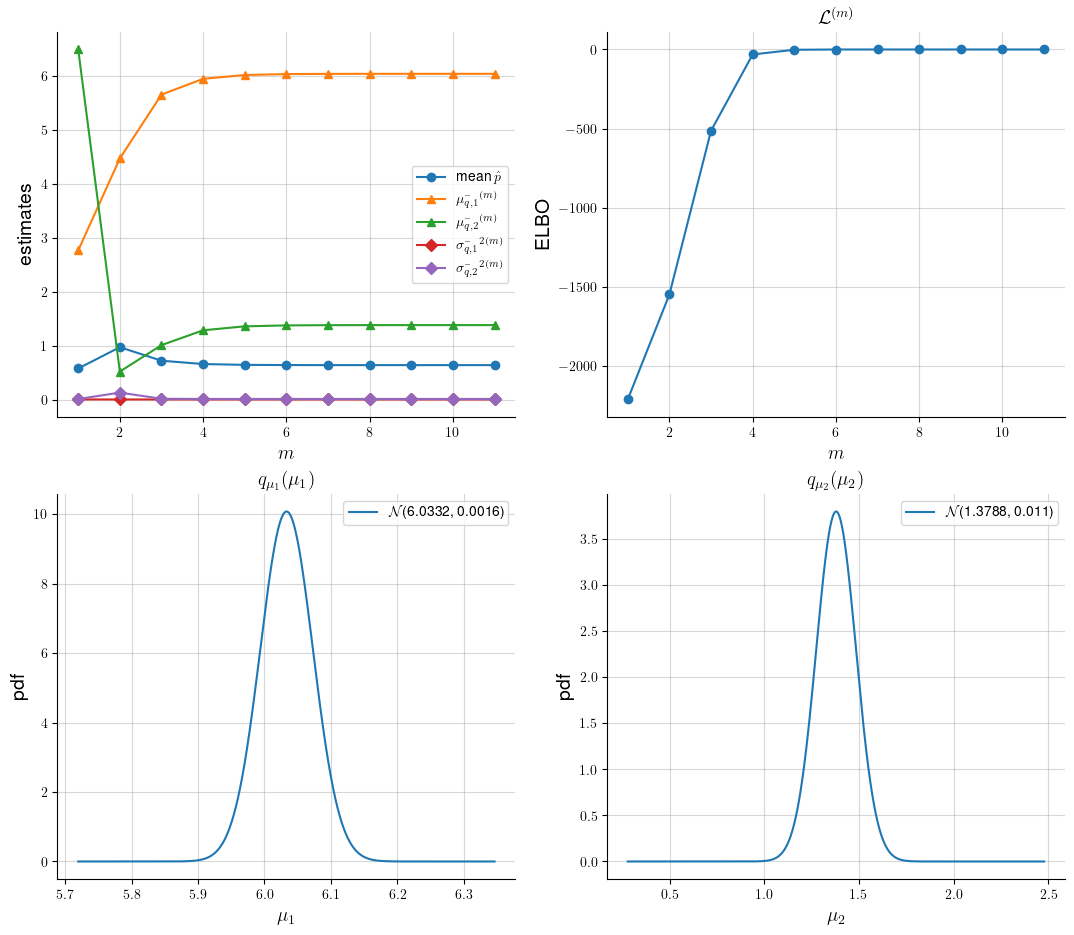

In [115]:
#figure 3 (estimates)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13,11
fig = plt.figure()

ax = fig.add_subplot(221)

ax.plot(np.arange(1, L+1), p_vec.mean(axis=0), label="mean $\hat{p}$", marker="o")
ax.plot(np.arange(1, L+1), mu_1_vec, label="$\\bar{\mu_{q, 1}}^{(m)}$", marker="^")
ax.plot(np.arange(1, L+1), mu_2_vec, label="$\\bar{\mu_{q, 2}}^{(m)}$", marker="^")
ax.plot(np.arange(1, L+1), sigma_1_vec, label="$\\bar{\sigma_{q, 1}}^{2(m)}$", marker="D")
ax.plot(np.arange(1, L+1), sigma_2_vec, label="$\\bar{\sigma_{q, 2}}^{2(m)}$", marker="D")
ax.set_xlabel("$m$", fontsize=14)
ax.set_ylabel("estimates", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

ax = fig.add_subplot(222)

ax.plot(np.arange(1, L+1), L_next, marker="o")
ax.set_xlabel("$m$", fontsize=14)
ax.set_ylabel("ELBO", fontsize=14)
ax.set_title("${\cal L}^{(m)}$", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(223)

ax.plot(x1, f1, label="${\cal N}$"+f"({np.round(mu_1_vec[-1], 4)}, {np.round(sigma_1_vec[-1], 4)})")
ax.set_xlabel("$\mu_1$", fontsize=14)
ax.set_ylabel("pdf", fontsize=14)
ax.set_title("$q_{\mu_1}(\mu_1)$", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

ax = fig.add_subplot(224)

ax.plot(x2, f2, label="${\cal N}$"+f"({np.round(mu_2_vec[-1], 4)}, {np.round(sigma_2_vec[-1], 4)})")
ax.set_xlabel("$\mu_2$", fontsize=14)
ax.set_ylabel("pdf", fontsize=14)
ax.set_title("$q_{\mu_2}(\mu_2)$", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

plt.show()

**Figure 36.3** Successive estimates of the parameters $(\bar{\mu}_1,\bar{\mu}_2,\sigma_1^2,\sigma_2^2)$ for the variational factors $q_{ {\mu}_1}(\mu_1)$, $q_{ {\mu}_2}(\mu_2)$, and $q_{k}(k)$ by applying algorithm (36.77) to $N=2000$ observations $\{y_n\}$ generated according to the Gaussian mixture model  (36.45).

We run a simulation by generating $N=2000$ observations $\{y_n\}$  according to the Gaussian mixture model (36.45)  using 
$\sigma_{1}^2=2,$ $\sigma_{2}^2=5$, $\sigma_{y,1}^2=1,$ $\sigma_{y,2}^2=4$, and $p=0.3$. We apply construction (36.77) starting from random initial conditions: 

$$\Bigl\{\bar{\mu}_{q,1}^{(-1)},\bar{\mu}_{q,2}^{(-1)},
\sigma_{q,1}^{2,(-1)}, \sigma_{q,2}^{2,(-1)},p_n^{(-1)}\Bigr\} \tag{36.85}
$$

The mean realizations used to generate the observations are $\mu_1=1.4554$ and $\mu_2=6.3255$. The results are shown in Fig. 36.3. It is seen that the ELBO value ${\cal L}^{(m)}$ converges quickly to its steady-state value. The resulting estimated parameters are:

$$
\begin{align*}
&\bar{\mu}_1+\bar{\mu}_{q,1}\approx 6.6323,\;\;\bar{\mu}_2+\bar{\mu}_{q,2}\approx 1.5558 \tag{36.86} \\
&\sigma_{q,1}^2\approx 0.0015,\;\;\;\sigma_{q,2}^2\approx 0.0117 \tag{36.87} \\
&\widehat{p}=0.7104 \tag{36.88}
\end{align*}
$$

where the estimate for $p$ is obtained by using (36.82) and the values of $\{ p_n\}$ when the algorithm stops. Figure 36.4 shows the predictive distribution (36.81) along with a normalized histogram for the observations. We generate an additional collection of $200$ observations and use (36.84) to predict their labels. The error rate is $88\%$. Observe, however, that the estimated models are switched: The mean estimated for model $1$ actually corresponds to model $2$ and vice-versa. Also, the value estimated for $p$ is switched with $1-p$. Therefore, the actual error rate is $12\%$ in this contrived example.

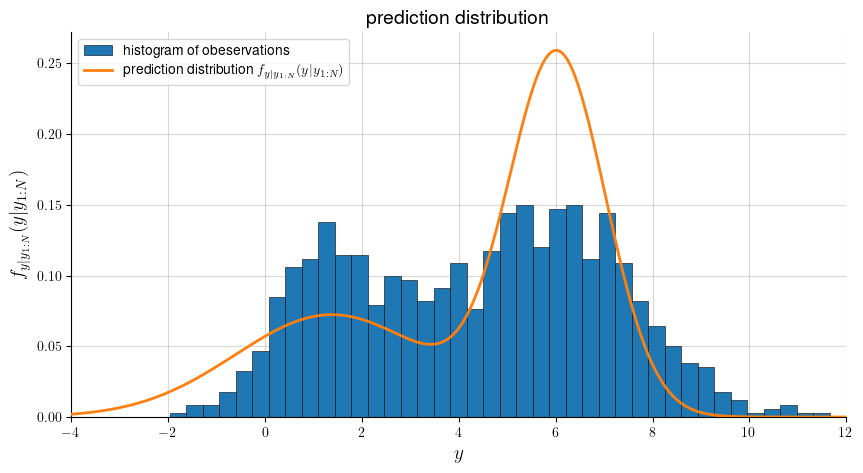

In [134]:
#figure 4 (prediction distribution)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
plt.rcParams['figure.figsize']=10,5
fig = plt.figure()

ax = fig.add_subplot(111)

ax.hist(y, bins=40, density=True, edgecolor="black", linewidth=0.4, zorder=2, label="histogram of obeservations")
ax.plot(range_x, fy, linewidth=2, zorder=3, label="prediction distribution $f_{{y}|{y}_{1:N}}(y|y_{1:N})$")
ax.set_xlabel("$y$", fontsize=14)
ax.set_ylabel("$f_{{y}|{y}_{1:N}}(y|y_{1:N})$", fontsize=14)
ax.set_title("prediction distribution", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim([-4, 12])
plt.legend()

plt.show()

**Figure 36.4** Histogram for $N=2000$ observations $\{y_n\}$ generated according to the Gaussian mixture model  (36.45), along with the predictive distribution (36.81).

## Example 36.4 (Estimating the posterior for probit models)

Let us reconsider the logit and probit models introduced in Chapter 33. There we explained that evaluation of the evidence (33.26) in closed form is not possible, which in turn meant that determining a closed-form expression for the posterior (33.25) was not possible either and it needed to be approximated. We showed in Example 33.1 how this approximation can be pursued for logit models by using the Laplace method. Here, we carry out the approximation  by relying on the coordinate-ascent  construction (36.44). For illustration purposes, we consider here the probit model, leaving the extension to the logit case to  Prob. 36.5.
 
 
To begin with, we showed in Prob. 33.6 that we can rewrite the probit model (33.21 in a convenient equivalent form. For any feature vector $h$, we introduce the Gaussian random variable $z\sim {\cal N}_{z}(h^{\sf T} w, 1)$ with mean $h^{\sf T} w$ and unit variance, and where $w$ is a realization from a Gaussian prior, $w\sim{\cal N}_{w}(0,\sigma_{w}^2 I_M)$. We verified in that problem that the probit model (33.21) can be equivalently rewritten in the form:

$$
\gamma=+1\;\textnormal{if}\;z>0,\;\;\textnormal{otherwise}\;\gamma=-1 \tag{36.91}
$$

In other words, the variable $\gamma$ will assume the value $+1$ with probability equal to that of the event $z>0$. We associate a local latent Gaussian variable $z_n$ with each observation $\gamma(n)$. These auxiliary latent variables will facilitate the evaluation of the expectations that arise during the application of the coordinate-ascent construction. We therefore end up with a generative model that contains one global latent variable, $w$, and $N$ local latent variables $\{z_n\}$:

$$
\left\{ \begin{array}{ll}
        \textnormal{generate } w\sim{\cal N}_{w}(0,\sigma_{w}^2 I_M) \\
        \textbf{for } \textnormal{each data point } n = 1, 2, ..., N \\
        \left\{ \begin{array}{ll}
                \textnormal{generate } z_n \sim{\cal N}_{z_n}(h_n^{\sf T}w, 1) \\
                \textnormal{set } \gamma(n) = +1 \textnormal{ if } z_n > 0 \textnormal{; otherwise, } \gamma(n) = -1
        \end{array} \right. \\
        \textbf{end}
\end{array} \right. \tag{36.92}
$$

Since we are denoting the class values by $+1$ and $-1$, we can express the assignment (36.91) by writing the pdf:

$$
f_{\gamma|z,w}(\gamma|z,w)\;=\;\left(\frac{1+\gamma}{2}\right)^{\mathbb{I}[z>0]}\,
\left(\frac{1-\gamma}{2}\right)^{\mathbb{I}[z\leq 0]} \tag{36.93}
$$

in terms of the indicator function. For example, when $z>0$, the first term $(1+\gamma)/2$ is retained. This term evaluates to $1$ when $\gamma=+1$  and to zero when $\gamma=-1$, thus placing the entire probability mass at location $\gamma=+1$. The above pdf expression depends on $w$ as well since the distribution of $z$ depends on it. It follows that the joint pdf of the latent variables and the observations is given by

$$
f_{w,z_{1:N},\gamma_{1:N}}(w,z_{1:N},\gamma_{1:N})=
f_{w}(w)\,\left(\prod_{n=1}^N f_{z|w}(z_n|w)\,f_{\gamma|z,w}(\gamma_n|z_n,w)\right) \tag{36.94}
$$

and, consequently,

$$
\begin{align*} &
\ln f_{w,z_{1:N},\gamma_{1:N}}(w,z_{1:N},\gamma_{1:N}) \\ &
=-\frac{1}{2\sigma_{w}^2}\|w\|^2-
\frac{1}{2}\sum_{n=1}^N (z_n-h_n^{\sf T} w)^2+\\ &
\sum_{n=1}^N \mathbb{I}[z_n>0]\ln \left(\frac{1+\gamma(n)}{2}\right)
+
\sum_{n=1}^N \mathbb{I}[z_n\leq 0]\ln \left(\frac{1-\gamma(n)}{2}\right)+C \tag{36.95}
\end{align*}
$$

where the constant collects all terms that are independent of the latent variables.

We are interested in estimating the posterior $f_{w,z_{1:N}|\gamma_{1:N}}(w,z_{1:N}|\gamma_{1:N})$. Based on the mean-field approximation method, we assume a factored form:

$$
f_{w,z_{1:N}|\gamma_{1:N}}(w,z_{1:N}|\gamma_{1:N})\approx 
q_{w}(w)\prod_{n=1}^N q_{z_n}(z_n) \tag{36.96}
$$

where, according to (36.42), the variational factors should satisfy the coupled equations (we are dropping the $\star$ superscript for convenience of notation):

$$
\begin{align*} &
\ln q_{w}(w)=\mathbb{E}{z_{1:N}}\,\Bigl(\ln f_{w,z_{1:N},\gamma_{1:N}}(w,z_{1:N},\gamma_{1:N})\Bigl) \tag{36.97a} \\ &
\ln q_{z_n}(z_n)=\mathbb{E}_{z_{-n},w}\,\Bigl(\ln f_{w,z_{1:N},\gamma_{1:N}}(w,z_{1:N},\gamma_{1:N})\Bigl) \tag{36.97b} \\ &
\textnormal{for}\;n=1,2,\ldots,N 
\end{align*}
$$

Here, again, the notation $\mathbb{E}_{a}(\cdot)$ on the right-hand side is used to refer to  expectation relative to the variational distribution of $a$, i.e., relative to $q_{a}(a)$.

Using (36.95) and (36.97b), taking expectations of the right-hand side, and keeping only terms that depend on $z_n$ we find that: 

$$
\begin{align*} 
& \ln q_{z_n}(z_n) \\
& \propto-\frac{1}{2}\mathbb{E}_{w}(z_n-h_n^{\sf T} w)^2+\mathbb{I}[z_n>0]\ln \left(\frac{1+\gamma(n)}{2}\right)
+
\mathbb{I}[z_n\leq 0]\ln \left(\frac{1-\gamma(n)}{2}\right)
\end{align*} \tag{36.98}
$$

where the expectation is relative to the variational distribution $q_{w}(w)$. Now note that

$$
\begin{align*} 
\mathbb{E}_{w}(z_n-h_n^{\sf T} w)^2 & =
\mathbb{E}_{w}\Bigl(z_n^2 -2z_n h_n^{\sf T} w + w^{\sf T} h_nh_n^{\sf T} w\Bigr) \\ &
=z_n^2 - 2z_n h_n^{\sf T} \mathbb{E}_{w}(w) + \textnormal{term independent of } z_n \\ &
=\Bigl(z_n-h_n^{\sf T} \mathbb{E}_{w}(w)\Bigr)^2 + \textnormal{term independent of } z_n \tag{36.99}
\end{align*}
$$

Substituting into (36.98) gives

$$
\begin{align*} &
\ln q_{z_n}(z_n) \\ & 
\propto-\frac{1}{2}\Bigl(z_n-h_n^{\sf T} \mathbb{E}_{w}(w)\Bigr)^2+\mathbb{I}[z_n>0]\ln \left(\frac{1+\gamma(n)}{2}\right)
+
\mathbb{I}[z_n\leq 0]\ln \left(\frac{1-\gamma(n)}{2}\right)
\end{align*} \tag{36.100}
$$

If the last two terms were not present and we exponentiate the right-hand side, then a Gaussian type distribution would result for $q_{z_n}(z_n)$ with mean $h_n^{\sf T} \mathbb{E}_{w}(w)$. However, the range of $z_n$ is coupled to the class variable $\gamma(n)$. Specifically, if $\gamma(n)=+1$, then it must hold that $z_n>0$; otherwise, $z_{n}\leq 0$. This means that the variational distribution for $z_n$ will either have its support over the positive real axis when $\gamma(n)=+1$ or over the negative real axis when $\gamma(n)=-1$. As such, the distribution for $z_n$ cannot be Gaussian, whose support extends over the entire real axis. Actually,  the variational distribution $q_{z_n}(z_n)$ will have a {\em truncated} Gaussian form. To see this, let us first note that if $x\sim{\cal N}_{x}(\mu,\sigma_{x}^2)$ denotes some generic Gaussian distribution over $x\in(-\infty,+\infty)$, then truncating it to the interval $x\in[a,b]$ results in a new distribution that is given by  (see Prob 36.8):

$$
f_{x,[a,b]}(x)=\left\{\begin{array}{cl}0,&x<a\\ \\
\dfrac{\frac{1}{\sqrt{2\pi\sigma_{x}^2}}\textnormal{{\small {exp}}}\left\{-\frac{1}{2\sigma_{x}^2}(x-\mu)^2\right\}}{\Phi((b-\mu)/\sigma_x)-\Phi((a-\mu)/\sigma_x)},&a\leq x\leq b\\ \\
0,&x>b
\end{array}\right. \tag{36.101}
$$

This  new pdf assumes zero values outside the interval $[a,b]$. The middle line includes the cumulative distribution $\Phi(\cdot)$ of the standard Gaussian, which was defined earlier in (33.20). The original normal distribution for $x$ appears in the numerator. A lower truncated Gaussian has $b=+\infty$ while an upper truncated Gaussian has $a=-\infty$. We denote them by writing ${\cal N}_{x>a}(\mu,\sigma_{x}^2)$ and ${\cal N}_{x<b}(\mu,\sigma_x^2)$, respectively. Therefore, we conclude that  

$$
q_{z_n}(z_n)=\left\{\begin{array}{ll}{\cal N}_{z>0}\Bigl(h_n^{\sf T} \mathbb{E}_{w}(w),1\Bigr),&\textnormal{when } \gamma(n)=+1\\ \\
{\cal N}_{z\leq 0}\Bigl(h_n^{\sf T} \mathbb{E}_{w}(w), 1\Bigr),&\textnormal{when } \gamma(n)=-1
\end{array}\right. \tag{36.102}
$$

For later use, we note that the mean of a general truncated distribution of the form (36.101) is given by

$$
\mathbb{E}_{x,[a,b]}\;=\;\mu + \sigma_x\,\frac{\phi\Bigl((a-\mu)/\sigma_x\Bigr)-\phi\Bigl((b-\mu)/\sigma_x\Bigr)}{
\Phi\Bigl((b-\mu)/\sigma_x\Bigr)-\Phi\Bigl((a-\mu)/\sigma_x\Bigr)} \tag{36.103}
$$

in terms of the normalized Gaussian function

$$
\phi(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}
$$

It follows for lower and upper truncated Gaussian distributions that

$$
\mathbb{E}_{x,x>a}=\mu + \sigma_x\frac{\phi\Bigl((a-\mu)/\sigma_x\Bigr)}{
1-\Phi\Bigl((a-\mu)/\sigma_x\Bigr)} \tag{36.104a}
$$

$$
\mathbb{E}_{x,x<b}=\mu - \sigma_x
\frac{\phi\Bigl((b-\mu)/\sigma_x\Bigr)}{
\Phi\Bigl((b-\mu)/\sigma_x\Bigr)} \tag{36.104b}
$$

Next, using (36.95) and (36.97a), taking expectations of the right-hand side, and keeping only terms that depend on $w$ we find that 

$$
\begin{align*}
\ln q_{w}(w) & \propto-\frac{1}{2\sigma_{w}^2}\|w\|^2-
\frac{1}{2}\sum_{n=1}^N \mathbb{E}_{z_{n}}(z_n-h_n^{\sf T} w)^2 \\ &
\propto-\frac{1}{2}w^{\sf T} \underbrace{\left(\frac{1}{\sigma_{w}^2}I_M+
\sum_{n=1}^N h_n h_n^{\sf T}\right)}_{\overset{\Delta}{=} R_w^{-1}}w+\left(\sum_{n=1}^N \mathbb{E}_{z_n}(z_n)h_n^{\sf T} \right) w \\ &
\propto -\frac{1}{2}(w-\bar{w})^{\sf T} R_w^{-1}(w-\bar{w})
\end{align*} \tag{36.105}
$$

where

$$
R_w^{-1}\overset{\Delta}{=} \frac{1}{\sigma_{w}^2}I_M+
\sum_{n=1}^N h_n h_n^{\sf T},\;\;\;\;\bar{w}\overset{\Delta}{=} R_{w}\left(\sum_{n=1}^N \mathbb{E}_{z_n}(z_n)h_n\right) \tag{36.106} 
$$

and the expectation is relative to the variational distribution $q_{z_n}(z_n)$. We conclude that $q_{w}(w)$ has a Gaussian distribution with mean $\bar{w}$ and covariance matrix $R_w$:

$$
q_{w}(w)\;=\;{\cal N}_{w}(\bar{w},R_w)\; \tag{36.107}
$$

We still need to evaluate $\mathbb{E}_{z_n}\,(z_n)$, which appears in the expression for $\bar{w}$ above. For this purpose, we introduce the scalar:

$$
\alpha_n\overset{\Delta}{=} h_n^{\sf T} \,\mathbb{E}_{w}\,(w) \overset{(36.107)}{=}h_n^{\sf T} \bar{w} \tag{36.108}
$$

Using (36.102) and (36.104a)--(36.104b) we have

$$
\mathbb{E}_{z_n}\,(z_n)=
\left\{\begin{array}{ll}\alpha_n + 
\dfrac{\phi(-\alpha_n)}{
1-\Phi(-\alpha_n)},&\textnormal{when } \gamma(n)=+1\\ \\
\alpha_n - 
\dfrac{\phi(-\alpha_n)}{
\Phi(-\alpha_n)},&\textnormal{when } \gamma(n)=-1
\end{array}\right. \tag{36.109}
$$

Using the symmetry properties $\phi(x)=\phi(-x)$, $\Phi(x)=\Phi(-x)$, and $\Phi(x)=1-\Phi(-x)$, we can rewrite the above result more compactly as

$$
\mathbb{E}_{z_n}\,(z_n)=\alpha_n +\gamma(n) 
\dfrac{\phi(\alpha_n)}{
\Phi(\alpha_n)}\overset{\Delta}{=} \beta_n \tag{36.110}
$$

In summary, we arrive at the following expressions for the sought-after variational factors:

$$
q_{z_n}(z_n)={\cal N}_{\gamma(n),z_n>0}(\alpha_n,1),\;\;\;\;\;\;
q_{w}(w)={\cal N}_{w}(\bar{w},R_w) \tag{36.111}
$$

where the notation used for $q_{z_n}(z_n)$ is a compact representation for (36.102) and
where the parameters are given by

$$
\left\{\begin{array}{l}
R_w= \left(\dfrac{1}{\sigma_{w}^2}I_M+\displaystyle
\sum_{n=1}^N h_n h_n^{\sf T}\right)^{-1}\\
\bar{w}=R_{w}\left(\displaystyle\sum_{n=1}^N \beta_n h_n\right) \\ \\
\beta_n=\alpha_n +\gamma(n) 
\dfrac{\phi(
\alpha_n)}{
\Phi(\alpha_n)}\\ \\
\alpha_n=
h_n^{\sf T} \bar{w}\end{array}\right. \tag{36.112}
$$

The expressions for $\{\bar{w},\alpha_n,\beta_n\}$ are coupled. We can iterate them to estimate the desired values:

$$
\begin{array}{ll}
\textbf{repeat for } m=0,1,2,\ldots: \\
\;\; \;\;\bar{w}^{(m)}=R_{w}\left(\displaystyle\sum_{n=1}^N \beta_n^{(m-1)} h_n\right) \\ \;\; \;\;\\
\;\;  \;\;\alpha_n^{(m)}=
h_n^{\sf T} \bar{w}^{(m)}\\ \;\;  \;\;\\
\;\; \;\; \beta_n^{(m)}=\alpha_n^{(m)} +\gamma(n) 
\dfrac{\phi\Bigl(\alpha_n^{(m)}\Bigr)}{
\Phi\Bigl(\alpha_n^{(m)}\Bigr)}\\
\textbf{end}\end{array} \tag{36.113}
$$

starting from some initial conditions $w^{(-1)}, \alpha_n^{(-1)},$ and $\beta_n^{(-1)}$. Once we converge to a value $\bar{w}$, we obtain a characterization for the variational factor $q_{w}(w)$. This factor approximates the conditional distribution of $w$ given the observations, i.e.,

$$
f_{w|\gamma_{N}}(w|\gamma_{N}; H_{N})\;\approx\;{\cal N}_{w}(\bar{w}, R_w) \tag{36.114}
$$

From this point onward we can follow the derivation from Example 33.1 after (33.44). Specifically, we can use the above distribution to  approximate the predictive distribution for $\gamma$ given a new feature $h$. Indeed, introduce the auxiliary scalar variable: 

$$
x\overset{\Delta}{=} \gamma h^{\sf T} w \tag{36.115}
$$

Conditioned on $\gamma$, and in view of the Gaussian distribution (36.114) for $w$ given all data, the variable $x$ is also Gaussian-distributed with mean and variance given by: 

$$
f_{x|\gamma_N}(x|\gamma_N; H_N)\approx {\cal N}_{x}(\gamma\, h^{\sf T} \bar{w},h^{\sf T} R_w h) \tag{36.116}
$$

Similar to (33.47), we can evaluate the predictive distribution as follows:

$$
\begin{align*} &
\mathbb{P}(\gamma=\gamma|\gamma_N= \gamma_N; h,H_N)\\ &
=\int_{-\infty}^{\infty} \Phi(x)\frac{1}{(2\pi h^{\sf T} R_w h)^{1/2}}\,\textnormal{exp}\left\{-\frac{1}{2 h^{\sf T} R_w h}(x-\gamma\, h^{\sf T} \bar{w})^2\right\}dx \tag{36.117}
\end{align*}
$$

The last integral is difficult to evaluate in closed form. However, it can be approximated by using property (33.49) to conclude that

$$
\mathbb{P}(\gamma=\gamma|\gamma_N= \gamma_N; h,H_N)\approx 
\Phi\left(\frac{\gamma h^{\sf T} \bar{w}}{\sqrt{1+h^{\sf T} R_w h}}\right) \tag{36.118}
$$

We illustrate this construction by means of a simulation. A total of $N=400$ feature vectors $\{h_n\in\mathbb{R}^{2}\}$ are generated randomly from a Gaussian distribution with zero mean and unit variance. The weight vector $w\in\mathbb{R}^{2}$ is also generated randomly from a Gaussian distribution with zero mean and variance $\sigma_{w}^2=2$. For each $h_n$, we assign its label to $\gamma(n)=+1$ with probability equal to $\Phi(h_n^{\sf T} w)$; otherwise, it is assigned to $\gamma(n)=-1$. 
The $400$ pairs $\{h_n,\gamma(n)\}$ generated in this manner are used for training (i.e., for learning the conditional and predictive distributions). These samples are shown in the top row of Fig. 36.5. We also generate separately $50$ additional sample pairs $\{h_n,\gamma(n)\}$ to be used during testing. These samples are shown in the plot on the left in the bottom row. Running recursions (36.113) for $100$ iterations leads to

$$
\bar{w} = 
\begin{bmatrix}
-2.0055 \\ -1.2971
\end{bmatrix}, \;\;\;
R_{w} =
\begin{bmatrix}
0.0022 & -0.0001 \\
-0.0001 & 0.0027
\end{bmatrix} \tag{36.119}
$$

Using these values, we can predict the label for each of the test features $h_n$ using construction (33.51). We assign $h_n$ to class $\gamma(n)=+1$ if

$$
\Phi\left(\frac{h^{\sf T} \bar{w}}{\sqrt{1+h^{\sf T} R_w h}}\right)\geq 1/2 
\;\;\Longrightarrow\;\gamma(n)=+1 \tag{36.120}
$$

The result is shown in the plot on the right in the bottom row of Fig. 36.5, with eight errors (corresponding to a 16\% error rate).

In [26]:
j1 = 0
j2 = 0
NT = 200
y_test = np.zeros(NT)
y1_test = np.zeros(NT)
y2_test = np.zeros(NT)
model_test = np.zeros(N)
prob_estimated_test = np.zeros(NT)
model_estimated_test = np.zeros(NT)

# generating test data
for n in range(NT):
    x = np.random.rand()
    if x <= p: # model 1
        mu = mu1
        y1_test[j1] = np.sqrt(sigma_y1)*np.random.randn() + mu
        y_test[n] = y1_test[j1]
        model_test[n] = 1
        j1 += 1
    else: # model 2
        mu = mu2
        y2_test[j2] = np.sqrt(sigma_y2)*np.random.randn() + mu
        y_test[n] = y2_test[j2]
        model_test[n] = 2
        j2 += 1

error = 0
for n in range(NT): #computing the likelihood for belonging to model k = 1 for each realization
    value1 = scalar_gaussian(y_test[n], mu_1_vec[-1], sigma_y1)
    value2 = scalar_gaussian(y_test[n], mu_2_vec[-1], sigma_y2)
    prob_estimated_test[n] = (estimate_p*value1)/(estimate_p*value1 + (1-estimate_p)*value2) # probability of belonging to model 1

    if prob_estimated_test[n] >= 0.5:
        model_estimated_test[n] = 1
    else:
        model_estimated_test[n] = 2
    if model_estimated_test[n] != model_test[n]:
        error += 1


print("Original: ")
print(f"p: {p}")
print(f"mu1: {mu1}")
print(f"mu2: {mu2}")
print(f"sigma1: {sigma_1}")
print(f"sigma2: {sigma_2}")

# estimate of p obtained by averaging last estimates across all N observations
print("Original: ")
print(f"p: {p_vec.mean()}")
print(f"mu1: {mu_1_vec[-1]}")
print(f"mu2: {mu_2_vec[-1]}")
print(f"sigma1: {sigma_1_vec[-1]}")
print(f"sigma2: {sigma_2_vec[-1]}")

print("Error in assigning correct model: ", (error/NT)*100)

# Remember that the mean estimated for model 1 can correspond to model 2 and vice-versa. 

Original: 
p: 0.3
mu1: -0.2874449925652325
mu2: 11.872884094529823
sigma1: 2
sigma2: 5
Original: 
p: 0.3228027065658518
mu1: -0.31797547499002277
mu2: 11.920103559734219
sigma1: 0.003262615593518556
sigma2: 0.005757073520660943
Error in assigning correct model:  0.0


In [40]:
N = 400 # number of training sample points
NT = 50 # test samples

M = 2 # dimension of w
sigma_w2 = 2 # variance of w
w = np.sqrt(sigma_w2)*np.random.randn(M) # generate a random model w
w_model = w

H = np.random.randn(M, N) # generate feature vectors
gamma_vec = np.zeros(N)

Htest = np.random.randn(M, NT)
gammatest = np.zeros(NT)

n1 = 0 # number of +1 samples
n2 = 0 # number of -1 samples

A1 = np.zeros((N, M))
A2 = np.zeros((N, M))
G1 = np.zeros(N)
G2 = np.zeros(N)

for n in range(N): # training samples
    h = H[:, n]
    x = norm.cdf(h.T@w)
    u = np.random.rand()
    if x >= u:
        gamma_vec[n] = +1
        A1[n1, :] = h.T 
        G1[n1] = gamma_vec[n]
        n1 += 1
    else:
        gamma_vec[n] = -1
        A2[n2, :] = h.T
        G2[n2] = gamma_vec[n]
        n2 += 1

A1 = A1[:n1]
A2 = A2[:n2]
G1 = G1[:n1]
G2 = G2[:n2]

n1 = 0 # number of +1 samples
n2 = 0 # number of -1 samples

A1_test = np.zeros((NT, M))
A2_test = np.zeros((NT, M))
G1_test = np.zeros(NT)
G2_test = np.zeros(NT)

for n in range(NT): # test samples
    h = Htest[:, n]
    x = norm.cdf(h.T@w)
    u = np.random.rand()
    if x >= u:
        gammatest[n] = +1
        A1_test[n1, :] = h.T 
        G1_test[n1] = gamma_vec[n]
        n1 += 1
    else:
        gammatest[n] = -1
        A2_test[n2, :] = h.T
        G2_test[n2] = gamma_vec[n]
        n2 += 1

A1tA1_testest = A1_test[:n1]
A2_test = A2_test[:n2]
G1_test = G1_test[:n1]
G2_test = G2_test[:n2]  

X = (1/sigma_w2)*np.eye(M)
for n in range(N):
    h = H[:, n]
    X += h.reshape(1, -1).T@h.reshape(1, -1)

Rw = np.linalg.inv(X)

beta_ = np.random.randn(N)
alpha = np.random.randn(N)
L = 5 # number of iterations to use
for m in range(L):
    ss = H@beta_
    w = Rw@ss
    for n in range(N):
        h = H[:, n]
        alpha[n] = h.T@w
        x = norm.pdf(alpha[n])
        y = norm.cdf(alpha[n])
        beta_[n] = alpha[n] + gamma_vec[n]*x/y

wbar = w

n1 = 0
n2 = 0
A1_after_testing = np.zeros(A1.shape)
A2_after_testing = np.zeros(A2.shape)
G1_after_testing = np.zeros(G1.shape)
G2_after_testing = np.zeros(G2.shape)

for n in range(NT): # testing
    h = Htest[:, n]
    a = h.T@wbar
    b = 1 + h.T@Rw@h
    b = np.sqrt(b)
    d = norm.cdf(a/b)
    if d >= 1/2:
        A1_after_testing[n1, :] = h.T
        G1_after_testing[n1] = 1
        n1 += 1
    else:
        A2_after_testing[n2, :] = h.T
        G2_after_testing[n2] = 1
        n2 += 1

A1_after_testing = A1_after_testing[:n1]
A2_after_testing = A2_after_testing[:n2]
G1_after_testing = G1_after_testing[:n1]
G2_after_testing = G2_after_testing[:n2]  

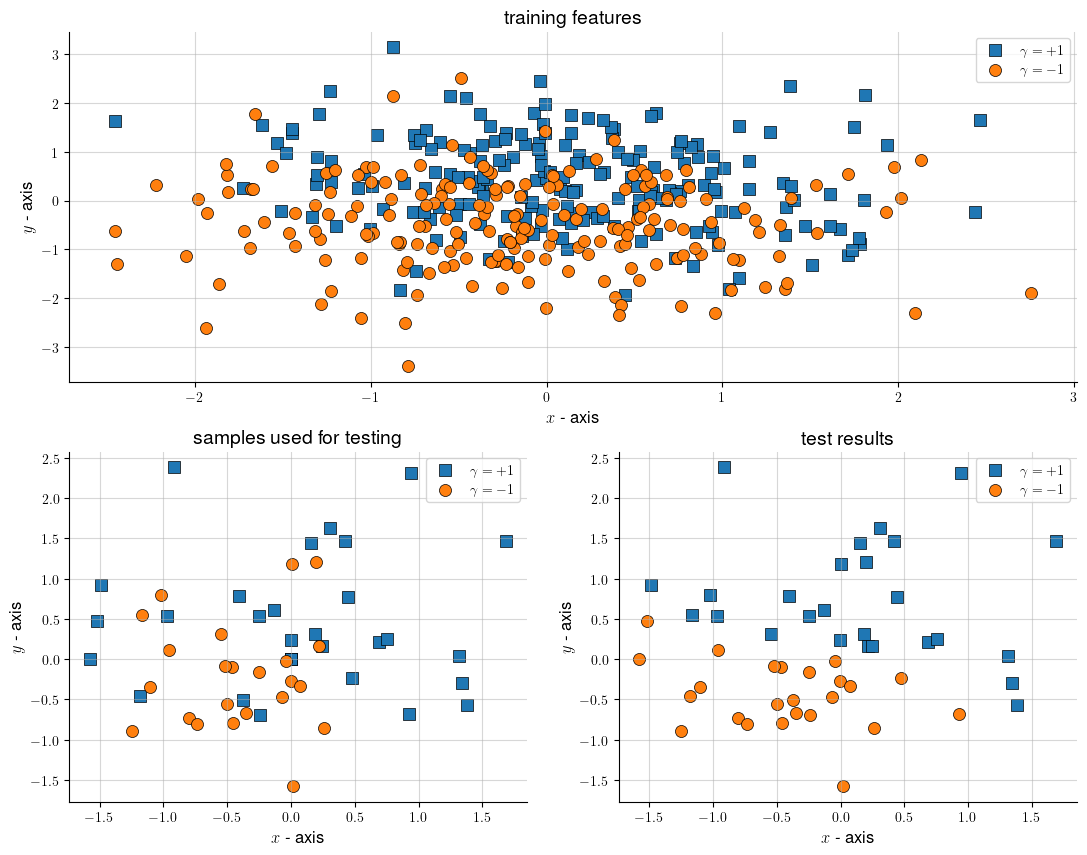

In [41]:
#figure 3 (scatter diagrams)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13,10
fig = plt.figure()

ax = fig.add_subplot(2, 2, (1, 2))

ax.scatter(A1[:, 0], A1[:, 1], marker="s", s=75, edgecolors="black", linewidths=0.5, label="$\gamma = +1$")
ax.scatter(A2[:, 0], A2[:, 1], s=75, edgecolors="black", linewidths=0.5, label="$\gamma = -1$")
ax.set_xlabel("$x$ - axis", fontsize=12)
ax.set_ylabel("$y$ - axis", fontsize=12)
ax.set_title("training features", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()


ax = fig.add_subplot(2, 2, 3)

ax.scatter(A1_test[:, 0], A1_test[:, 1], marker="s", s=75, edgecolors="black", linewidths=0.5, label="$\gamma = +1$")
ax.scatter(A2_test[:, 0], A2_test[:, 1], s=75, edgecolors="black", linewidths=0.5, label="$\gamma = -1$")
ax.set_xlabel("$x$ - axis", fontsize=12)
ax.set_ylabel("$y$ - axis", fontsize=12)
ax.set_title("samples used for testing", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

ax = fig.add_subplot(2, 2, 4)

ax.scatter(A1_after_testing[:, 0], A1_after_testing[:, 1], marker="s", s=75, edgecolors="black", linewidths=0.5, label="$\gamma = +1$")
ax.scatter(A2_after_testing[:, 0], A2_after_testing[:, 1], s=75, edgecolors="black", linewidths=0.5, label="$\gamma = -1$")
ax.set_xlabel("$x$ - axis", fontsize=12)
ax.set_ylabel("$y$ - axis", fontsize=12)
ax.set_title("test results", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

plt.show()

**Figure 36.5** ($\textit{Top row}$) A total of $N=400$ pairs $(h_n,\gamma(n))$ used for training in order to learn the predictive distribution. ($\textit{Bottom row}$) The plot on the left shows the $50$ pairs $\{h_n,\gamma(n)\}$ used for testing. The plot on the right shows the labels that are assigned by the test (33.51) to these points.

## Example 36.5 (Legislative voting record)

We examine next a  more involved generative model in the context of legislative voting. Consider a legislative body consisting of  $N$ members (say, $N$ senators). Assume we collect the voting record of the senators on  $L$ legislative issues. The objective is to  infer from the data whether there is some natural grouping that occurs within the legislative body. Do some senators tend to vote together on certain issues? Assume the senators can be divided into $B$ groups or blocks, where senators in the same block tend to vote similarly on legislative issues presented to them. We would like to identify which senators belong to each block. Before we address this problem by means of variational inference, let us first introduce a generative model to explain the data (i.e., the voting record).
 
For each senator $n$, we let $g_n$ denote the index of the group (or block) that the senator belongs to with

$$
\mathbb{P}(g_n=b)=\pi_b,\;\;\;b=1,2,\ldots,B \tag{36.121}
$$

The variable $g_n$ follows a categorical distribution defined by the $B\times 1$ vector of probabilities $\pi=\textnormal{col}\{\pi_1,\pi_2,\ldots,\pi_B\}$; the class $g_n$  assumes one of the values $b=1,2,\ldots,B$ with probability $\pi_b$. In this way,  the likelihood that senator $n$ belongs to the $b$th block is $\pi_b$, with all the $\{\pi_b\}$ adding up to 1. Each senator can belong to only one block.  We model $ {\pi}$ as arising from a Dirichlet distribution with positive scalar parameters $\{\alpha_1,\alpha_2,\ldots,\alpha_B\}$, collected into a column vector $\alpha$. Recall that Dirichlet distributions are useful for generating realizations of probability vectors such as $\pi$.  According to (5.53), this means that the pdf of $ {\pi}$ takes the form 

$$
f_{ {\pi}}(\pi)\;=\;K(\alpha)\left(\prod_{b=1}^{B} \pi_{b}^{\alpha_b-1}\right),\;\;\;\;
K(\alpha)=
\Gamma\Bigl(\sum_{b=1}^{B} \alpha_{b}\Bigr)\Bigl/\prod_{b=1}^{B}\Gamma(\alpha_{b}) \tag{36.122}
$$

where $\Gamma(\cdot)$ is the gamma function. We refer to the $\{\alpha_b\}$ as the ``proportion'' parameters;  smaller or larger values for these parameters can end up concentrating the senators into fewer groups or dispersing them among more groups. We recall from (5.66) that every Dirichlet distribution of the above form  belongs to the exponential family of distributions. Specifically, we can write

$$
f_{ {\pi}}(\pi)=h(\pi)e^{\alpha^{\sf T} T(\pi)-a(\alpha)}\; \tag{36.123a}
$$

where 

$$
\alpha \overset{\Delta}{=}  
\begin{bmatrix}
\alpha_1 \\ \alpha_2 \\ ... \\ \alpha_B
\end{bmatrix}, \quad
T(\pi) \overset{\Delta}{=}
\begin{bmatrix}
ln(\pi_1) \\ ln(\pi_2) \\ ... \\ ln(\pi_B)
\end{bmatrix}, \quad
h(\pi)=1\Bigl/\prod_{b=1}^B \pi_b \tag{36.123b}
$$

as well as 

$$
a(\alpha)=\sum_{b=1}^B \ln \Gamma(\alpha_b)-\ln \Gamma\Bigl(\sum_{b=1}^B\alpha_b\Bigr) \tag{36.123c}
$$

It follows that 

$$
\begin{align*}
f_{ {\pi}}(\pi)& =\frac{1}{\prod_{b=1}^B \pi_b}
\textnormal{exp}\left\{\sum_{b=1}^B \alpha_b \ln (\pi_b)-a(\alpha)\right\} \\ &
=\textnormal{exp}\left\{\left(\sum_{b=1}^B \alpha_b\ln (\pi_b)\right)-\ln\Bigl(\prod_{b=1}^B \pi_b\Bigr) -a(\alpha)\right\} \\ &
=\textnormal{exp}\left\{\left(\sum_{b=1}^B (\alpha_b-1) \ln (\pi_b)\right)-a(\alpha)\right\} \\ &
\propto \textnormal{exp}\left\{\sum_{b=1}^B (\alpha_b-1) \ln (\pi_b)\right\}
\end{align*} \tag{36.124}
$$

We will call upon this form later in the discussion; its purpose is to assist us in identifying exponential distributions.

We assume next that the senators vote on $L$ legislative issues. Let $ {\theta}_{b,\ell}$ denote the likelihood (i.e., probability) that senators in block $b$ would support legislation $\ell$. There are $L$ such likelihoods for each block $b$; one for each legislative item. We collect them into a vector of size $L\times 1$:

$$
\begin{align*} &
\theta_b\overset{\Delta}{=} \textnormal{col}\{\theta_{b,1},\,\theta_{b,2},\ldots,\theta_{b,L}\} \tag{36.125} \\ &
\theta_{b,\ell}= \textnormal{likelihood of block } b \textnormal{voting in favor of legislation } \ell \tag{36.126}
\end{align*}
$$


The entries of $\theta_b$ are nonnegative. If we select a senator $n$ from block $b$, the likelihood that this senator's vote on legislation $\ell$, denoted by $v_{n,\ell}$, will be in the affirmative  is given by

$$
\mathbb{P}\Bigl(v_{n,\ell}=1|g_n=b;\,\theta_{b,\ell}\Bigr)\;=\;\theta_{b,\ell} \tag{36.127}
$$

This means that the vote $v_{n,\ell}\in\{0,1\}$ is a Bernoulli variable with success probability given by $\theta_{b,\ell}$. We can model the distribution of the observations (i.e., the votes) by writing

$$
f_{v_{n,\ell}|g_n}\Bigl(v_{n,\ell}|g_n;\{\theta_{b,\ell}\}\Bigr)\;=\;\prod_{b=1}^B
\theta_{b,\ell}^{\mathbb{I}[g_n=b]v_{n,\ell}}\,
(1-\theta_{b,\ell})^{\mathbb{I}[g_n=b](1-v_{n,\ell})} \tag{36.127}
$$

Only one term inside the product expression will be active at a time (the one corresponding to the actual block for the $n$th member), with all other terms inside the product evaluating to 1.
 
We model each $\theta_{b,\ell}$ as being beta-distributed with parameters $(\lambda_1,\lambda_2)$, say, 

$$
f_{\theta_{b,\ell}}(\theta_{b,\ell})=\textnormal{beta}(\lambda_1,\lambda_2)=
\frac{\Gamma(\lambda_1+\lambda_2)}{\Gamma(\lambda_1)\Gamma(\lambda_2)}\,\theta_{b,\ell}^{\lambda_1-1}(1-\theta_{b,\ell})^{\lambda_2-1} \tag{36.129}
$$

Recall that beta distributions are useful in generating realizations for the probability variable of a Bernoulli distribution. According to  (5.66),  every beta distribution of the above form  belongs to the exponential family of distributions as well. In this case, we can write 

$$
f_{\theta_{b,\ell}}(\theta_{b,\ell})=h(\theta_{b,\ell})
e^{\lambda^{\sf T} T(\theta_{b,\ell})-s(\lambda)} \tag{36.130a}
$$

where

$$
\lambda \overset{\Delta}{=}
\begin{bmatrix}
\lambda_1 \\ \lambda_2
\end{bmatrix}, \quad
T(\theta_{b, l}) \overset{\Delta}{=} 
\begin{bmatrix}
ln(\theta_{b, l}) \\ ln(1 - \theta_{b, l})
\end{bmatrix} \quad
h(\theta_{b, l}) = \frac{1}{\theta_{b, l}(1 - \theta_{b, l})} \tag{36.130b}
$$

as well as 

$$
s(\lambda)=\ln \Gamma(\lambda_1)+\ln\Gamma(\lambda_2)-\ln\Gamma(\lambda_1+\lambda_2) \tag{36.130c}
$$

It follows, after some simple algebra similar to (36.124), that 

$$
f_{\theta_{b,\ell}}(\theta_{b,\ell})
\propto \textnormal{exp}\Bigl\{(\lambda_1-1) \ln (\theta_{b,\ell})+(\lambda_2-1)\ln(1-\theta_{b,\ell})\Bigr\} \tag{36.131}
$$

We therefore have the following generative model for the voting record of the members of the legislative body:

$$
\left\{ \begin{array}{ll}
        \textnormal{generate Bx1 probability vector } \pi \sim \textnormal{Dirichlet}(\alpha) \\ \\
        \textnormal{generate } \theta_{b, l} \sim \textnormal{beta}(\lambda_1, \lambda_2), b = 1, ..., B, l = 1, ..., L \\ \\
        \textbf{for} \textnormal{each senator } n = 1, 2, ..., N: \\ \\
        \left\{ \begin{array}{ll}
                \textnormal{let } g_n \textnormal{ denote the group or block assigment for senator n, where the assigments follows } g_n \sim \textnormal{Categorical}(\pi) \\ \\
                \textbf{for } \textnormal{each legislative issue } l = 1, 2, ..., L: \\ \\
                \left\{ \begin{array}{ll}
                        \textnormal{generate teh senator vote } v_{n, l} = \textnormal{Bernoulli}(\theta_{g_n, l})
                \end{array} \right. \\ \\
                \textbf{end}
        \end{array} \right. \\ \\
        \textbf{end}
\end{array} \right. \tag{36.132}
$$

The observations in this problem consist of the voting record $\{v_{n,\ell}\}$ for all senators $n=1,2,\ldots,N$ and for all legislative issues $\ell=1,2,\ldots, L$. The variables $\{g_n\}$ are local latent variables, while $\{\pi, \theta_{b,\ell}\}$ are global latent variables.   For compactness of notation, we collect the various quantities into vectors or matrices: 

$$
\begin{align*}
V\overset{\Delta}{=} & [v_{n,\ell}]_{n=1,\ell=1}^{N,L}\;\;\;\;(N\times L)\\ &
(\textnormal{collection of votes by } N \textnormal{ senators on } L \textnormal{pieces of legislation}) \tag{36.133a}
\end{align*}
$$

$$
\begin{align*}
\Theta= &[\theta_{b,\ell}]_{b=1,\ell=1}^{B,L}\;\;\;\;\;(B\times L)\\ &
(\textnormal{likelihoods of voting by the } B \textnormal{ blocks on the } L \textnormal{pieces of legislation})
\end{align*} \tag{36.133b} 
$$

$$
\begin{align*}
g\overset{\Delta}{=} &\textnormal{col}\{g_n\}_{n=1}^N\;\;\;\;\;\;(N\times 1)\\ &
(\textnormal{block assignments for all senators})
\end{align*} \tag{36.133c}
$$

Conditioned on block assignments, the entries of $V$ are Bernoulli-distributed with success probabilities given by the entries of $\Theta$. The entries of $\Theta$ are beta-distributed with parameters $(\lambda_1,\lambda_2)$, while the entries of $g$ follow a categorical distribution with parameter vector $\pi$. The joint distribution of all observations $V$ and the latent variables $\{ {\pi},\theta,g\}$ is given by:

$$
\begin{align*} &
f_{\pi,\Theta,g,V}(\pi,\Theta,g,V) \\ &
=f_{\pi}(\pi)f_{\Theta}(\Theta)f_{g|\pi}(g|\pi)f_{V|g,\Theta}(V|g,\Theta) \\ &
=f_{\pi}(\pi)\,\left(\prod_{b=1}^B\prod_{\ell=1}^L f(\theta_{b,\ell})\right)\,
\left(\prod_{n=1}^N\prod_{b=1}^B \pi_b^{\mathbb{I}[g_n=b]}\right)\times \\ & \quad\quad
\prod_{n=1}^N\prod_{\ell=1}^L\left(\prod_{b=1}^B \theta_{b,\ell}^{\mathbb{I}[g_n=b]v_{n,\ell}}(1-\theta_{b,\ell})^{\mathbb{I}[g_n=b](1-v_{n,\ell})}\right)
\end{align*} \tag{36.134}
$$

Consequently, by collecting all terms that are independent of the latent variables into a constant $C$ and grouping the remaining terms, the log-likelihood becomes

$$
\begin{align*} &
\ln f_{\pi,\Theta,g,V}(\pi,\Theta,g,V) \\ &
=\sum_{b=1}^B \Bigl(\alpha_b-1+\sum_{n=1}^N \mathbb{I}[g_n=b]\Bigr)\ln(\pi_b)+ \\ &
\;\;\;\;\sum_{b=1}^B\sum_{n=1}^N\sum_{\ell=1}^L 
\Bigl(\frac{1}{N}(\lambda_1-1)+ \mathbb{I}[g_n=b]v_{n,\ell}\Bigr)\ln(\theta_{b,\ell})+ \\ &
\;\;\;\;\sum_{b=1}^B\sum_{n=1}^N\sum_{\ell=1}^L \Bigl(\frac{1}{N}(\lambda_2-1)+\mathbb{I}[g_n=b](1-v_{n,\ell})\Bigr)\ln(1-\theta_{b,\ell})+C
\end{align*} \tag{36.135}
$$

Under the mean-field approximation, we estimate the conditional distribution of the latent variables given the observations in factored form, i.e., we adopt the model

$$
\begin{align*}
f_{\pi,\Theta,b|V}(\pi,\Theta,b|V)&\approx q_{\pi}(\pi)\,q_{\Theta}(\Theta)\,q_{g}(g)\\ &
=q_{\pi}(\pi)\left(\prod_{b=1}^B\prod_{\ell=1}^L q_{\theta_{b,\ell}}(\theta_{b,\ell})\right)\,\left(
\prod_{n=1}^N q_{g_n}(g_n)\right)
\end{align*} \tag{36.136}
$$

According to (36.42), the individual variational factors should satisfy the coupled equations (we drop the $\star$ superscript for convenience of notation):

$$
\begin{align*} &
\ln q_{\pi}(\pi)=\mathbb{E}_{g,\Theta}\,\Bigl(\ln f_{\pi,\theta,g,V}(\pi,\Theta,g,V)\Bigl) \tag{36.137a} \\ &
\ln q_{\theta_{b,\ell}}(\theta_{b,\ell})=\mathbb{E}_{ {\pi},g,\Theta_{-b,-\ell}}\,\Bigl(\ln f_{\pi,\Theta,b,V}(\pi,\Theta,g,V)\Bigl) \tag{36.137b} \\ &
\ln q_{g_n}(g_n)=\mathbb{E}_{ {\pi},g_{-n},\Theta}\,\Bigl(\ln f_{\pi,\Theta,g,V}(\pi,\Theta,g,V)\Bigl) \tag{36.137c}
\end{align*} 
$$

where the expectations are relative to the variational distributions. Let us examine (36.137c) first. We know from (36.121) that the entries of $g_n$ follow a categorical distribution, i.e.,

$$
\mathbb{P}(g_n=b)\overset{\Delta}{=} f_{g_n}(g_n=b)\;=\;\prod_{b=1}^B {\pi}_b^{\;\mathbb{I}[g_n=b]} \tag{36.138}
$$

We seek a similar distribution for the variational factor $q_{g_n}(g_n)$ and denote the individual probabilities by $\{\widehat{\pi}_{n,b}\}$ (i.e., there is one estimate $\widehat{\pi}_{n,b}$ for each sample $n$), namely, we assume

$$
\mathbb{P}(g_n=b|V)\overset{\Delta}{=} 
q_{g_n}(g_n)\;=\;\prod_{b=1}^B \widehat{\pi}_{n,b}^{\;\mathbb{I}[g_n=b]} \tag{36.139}
$$

Then, for a given $n$ and $g_n=b$, relations (36.135) and (36.137c) would imply the following probability value (where we are ignoring terms that are independent of $\pi_b$): 

$$
\begin{align*} &
\ln \widehat{\pi}_{n,b} \\ &
=\left\{ \mathbb{E}_{\pi}\Bigl(\ln(\pi_b)\Bigr)+\sum_{\ell=1}^L v_{n,\ell}\mathbb{E}_{\Theta}\Bigl(\ln(\theta_{b,\ell}\Bigr)- \sum_{\ell=1}^Lv_{n,\ell}\,\mathbb{E}_{\Theta}\Bigl(\ln(1-\theta_{b,\ell})\Bigr)\right\}+C'
\end{align*} \tag{36.140}
$$

We will verify soon in (36.152) and (36.154) that the variational factor for $\pi$ has a Dirichlet form with $B\times 1$ parameter vector $\widehat{\alpha}=\textnormal{col}\{\widehat{\alpha}_b\}$, while the variational factor for each $\theta_{b,\ell}$ has a beta form with parameters $(\widehat{\lambda}_{b\ell,1},\widehat{\lambda}_{b\ell,2})$. We can therefore use property (5.60) for the mean of the logarithm of a Dirichlet-distributed variable (of which the beta distribution is a special case) to deduce that:

$$
\mathbb{E}_{\pi}\Bigl(\ln(\pi_b)\Bigr)=
\psi(\widehat{\alpha}_b)-\psi\Bigl(\sum_{b'=1}^B \widehat{\alpha}_b'\Bigr) \tag{36.141}
$$

in terms of the digamma function $\psi(x)$ defined as the ratio of the derivative of the gamma function to itself:

$$
\psi(x)\overset{\Delta}{=} \frac{d}{dx}\ln \Gamma(x)=\frac{\Gamma'(x)}{\Gamma(x)} \tag{36.142}
$$

We provided in (5.62) one expression for evaluating the digamma function:

$$
\psi(x)\approx -0.577215665 + \sum_{m=0}^{\infty}\left(\frac{1}{1+m}-\frac{1}{x+m}\right) \tag{36.143}
$$

This expression can be used to approximate $\psi(x)$ by replacing the infinite series by a finite sum. Likewise, since the beta distribution is a special case of the Dirichlet distribution, we conclude from property (5.60) that

$$
\begin{align*} &
\mathbb{E}_{\Theta}\Bigl(\ln(\theta_{b,\ell})\Bigr)=
\psi(\widehat{\lambda}_{b\ell,1})-\psi\Bigl(\widehat{\lambda}_{b\ell,1}+\widehat{\lambda}_{b\ell,2}\Bigr) \tag{36.144a} \\ &
\mathbb{E}_{\Theta}\Bigl(\ln(1-\theta_{b,\ell})\Bigr)=
\psi(\widehat{\lambda}_{b\ell,2})-\psi\Bigl(\widehat{\lambda}_{b\ell,1}+\widehat{\lambda}_{b\ell,2}\Bigr) \tag{36.144b}
\end{align*}
$$

Substituting into (36.140) we find that

$$
\widehat{\pi}_{n,b}
\propto \textnormal{exp}\left\{\psi(\widehat{\alpha}_b)-\psi\Bigl(\sum_{b'=1}^B \widehat{\alpha}_b'\Bigr)+\sum_{\ell=1}^L v_{n,\ell}\left(\psi(\widehat{\lambda}_{b\ell,1})-\psi(\widehat{\lambda}_{b\ell,2})\right)\right\} \tag{36.145}
$$


 We can normalize the $\widehat{\pi}_{n,b}$ to add up to 1 by 
setting, for each $n$:

$$
\widehat{\pi}_{n,b}\leftarrow \widehat{\pi}_{n,b}\Bigr/\sum_{b'=1}^B \widehat{\pi}_{n,b'} \tag{36.146}
$$

$\textbf{Remkar 36.2 (Possibility of overflow and/or underflow)}$
 Some care is needed in the numerical implementation of this procedure due to the exponentiation in (36.145) and the possibility of overflow or underflow. If the number in the exponent assumes large values, then $\widehat{\pi}_{n,b}$ given by (36.145) can saturate in finite-precision implementations. One way to avoid this possibility is as follows. Assume, for illustration purposes, that we have a collection of exponential quantities of the form $\pi_k=e^{a_k}$, which we would like to normalize to add up to 1, i.e., we would like to replace each $\pi_k$ by 

$$
\pi_k\leftarrow \frac{e^{a_k}}{\sum_{k'=1}^K e^{a_{k'}}} \tag{36.147}
$$

The difficulty is that some of the $\{a_k\}$ may assume large values,  thus leading to saturation when attempting to compute $e^{a_k}$. This problem can be avoided by subtracting from all the $\{a_k\}$ their largest value and introducing:

$$
b_k\overset{\Delta}{=} a_k-\max_{1\leq k'\leq K}\Bigl\{a_{k'}\Bigr\} \tag{36.148}
$$

By doing so, the largest value of the $\{b_k\}$ will be zero. It is easy to see that using the $\{b_k\}$ instead of the $\{a_k\}$ does not change the value of the normalized $\{\pi_k\}$:

$$
\pi_k\leftarrow \frac{e^{b_k}}{\sum_{k'=1}^K e^{b_{k'}}} \tag{36.149}
$$



Let us now return to (36.137b). For a given $b$ and $\ell$, using  (36.135), relation (36.137b) implies (where we are ignoring terms that are independent of $\theta_{b,\ell}$):

$$
\begin{align*}
\ln q_{\theta_{b,\ell}}(\theta_{b,\ell})
& = \Bigl((\lambda_1-1)+ \sum_{n=1}^N \mathbb{E}_{g} (\mathbb{I}[g_n=b]v_{n,\ell})\Bigr)\ln(\theta_{b,\ell})+ \\ &
 \Bigl((\lambda_2-1)+\sum_{n=1}^N\mathbb{E}_{g}\Bigl[\mathbb{I}[g_n=b](1- v_{n,\ell})\Bigr]\Bigr)\ln(1-\theta_{b,\ell})+C''
\end{align*} \tag{36.150}
$$

where the expectation is relative to the variational distribution of $g$. Using (36.127) we readily recognize that

$$
\mathbb{E}_{g}\Bigl( \mathbb{I}[g_n=b]\,v_{n,\ell}\Bigr)=\mathbb{P}(g_n=b)v_{n,\ell}=\widehat{\pi}_{n,b} v_{n,\ell} \tag{36.150}
$$

Using the analogy with (36.131) for beta distributions, we conclude from (36.150) that 

$$
\begin{align*} &
q_{\theta_{b,\ell}}(\theta_{b,\ell})
=\textnormal{beta}(\,\widehat{\lambda}_{b\ell,1},\widehat{\lambda}_{b\ell,2}) \\ &
\widehat{\lambda}_{b\ell,1} = \lambda_1+\displaystyle \sum_{n=1}^N \widehat{\pi}_{n,b} v_{n,\ell}\\ &
\widehat{\lambda}_{b\ell,2} = \lambda_2+\displaystyle \sum_{n=1}^N \widehat{\pi}_{n,b}(1- v_{n,\ell})
\end{align*} \tag{36.152}
$$
 
Let us now consider (36.137a). Using  (36.135), the  relation implies

$$
\begin{align*}
\ln q_{\pi}(\pi)
&=\sum_{b=1}^B \Bigl(\alpha_b-1+\sum_{n=1}^N \mathbb{E}_{g}\,\mathbb{I}[g_n=b]\Bigr)\ln(\pi_b)+C''' \\ &
=\sum_{b=1}^B \Bigl(\alpha_b-1+\sum_{n=1}^N \widehat{\pi}_{n,b}\Bigr)\ln(\pi_b)+C'''
\end{align*} \tag{36.153}
$$

Comparing with (36.124) we conclude that the variational factor for $\pi$ has a Dirichlet form:

$$
\begin{align*} &
q_{\pi}(\pi)=\textnormal{Dirichlet}(\widehat{\alpha}) \\ &
\widehat{\alpha}=\textnormal{col}\Bigl\{\widehat{\alpha}_b\Bigr\}_{b=1}^B \\ &
\widehat{\alpha}_b=\alpha_b+\displaystyle \sum_{n=1}^N \widehat{\pi}_{n,b}
\end{align*} \tag{36.154}
$$

In summary, we arrive at listing (36.155)  for estimating the distributions of the latent variables in model (36.132) conditioned on the observations. 


$$
\left\{ \begin{array}{ll}
        \textbf{Coordinate-ascent algorithm for generative model (36.132).} \\ \\
        \textbf{input} \textnormal{: N x L votes } \{v_{n,\ell}\} \textnormal{ arising from model (36.132).} \\ \\
        \textbf{given} \textnormal{: parameters } \lambda_1, \lambda_2 \textnormal{ and } \{\alpha_b\}_{b=1}^B \\ \\
        \textbf{initial conditions: } \Bigl\{\widehat{\lambda}_{b\ell,1}^{(-1)}, \widehat{\lambda}_{b\ell,2}^{(-1)}\Bigr\}_{b=1,\ell=1}^{B,L} \textnormal{ and } \Bigl\{\widehat{\alpha}_b^{(-1)}\Bigr\}_{b=1}^B \\ \\
        \textbf{repeat until convergence over } m = 0, 1, 2, ... \\ \\
        \left\{ \begin{array}{ll}
                a_{b,1}=\psi\Bigl(\widehat{\alpha}_b^{(m-1)}\Bigr)-\psi\Bigl(\sum_{b'=1}^B \widehat{\alpha}_{b'}^{(m-1)}\Bigr),\;\;b=1,2,\ldots,B \\ \\
                a_{b\ell,2}=\psi\Bigl(\widehat{\lambda}_{b\ell,1}^{(m-1)}\Bigr)-\psi\Bigl(\widehat{\lambda}_{b\ell,2}^{(m-1)}\Bigr),\;\;\begin{array}{l}b=1,2,\ldots,B\\
                \ell=1,2,\ldots,L\end{array} \\ \\
                \widehat{\pi}_{n,b}^{(m)}
                \propto \textnormal{exp}\left\{\left(a_{b,1}+\displaystyle \sum_{\ell=1}^La_{b\ell,2}\, v_{n,\ell}\right)\right\} \\ \\
                \widehat{\pi}_{n,b}^{(m)}\leftarrow 
                \widehat{\pi}_{n,b}^{(m)}\Bigr/\displaystyle \sum_{b'=1}^B \widehat{\pi}_{n,b'}^{(m)},\;\;\begin{array}{l}n=1,2,\ldots,N\\
                b=1,2,\ldots,B\end{array} \\ \\
                \widehat{\lambda}_{b\ell,1}^{(m)}=\lambda_1+\displaystyle \sum_{n=1}^N \widehat{\pi}_{n,b}^{(m)} v_{n,\ell},\;\;\begin{array}{l}b=1,2,\ldots,B\\
                \ell=1,2,\ldots,L\end{array}\\ \\
                \widehat{\lambda}_{b\ell,2}^{(m)}=\lambda_2+\displaystyle \sum_{n=1}^N \widehat{\pi}_{n,b}^{(m)} (1-v_{n,\ell}) \\ \\
                \widehat{\alpha}_b^{(m)}=\alpha_b+\displaystyle \sum_{n=1}^N \widehat{\pi}_{n,b}^{(m)},\;\;b=1,2,\ldots, B\\
        \end{array} \right. \\
        \textbf{end} \\ \\
\end{array} \right. \tag{36.155}
$$

Once convergence is attained, we can estimate the parameters by using the estimates at the end of the recursions to compute:

$$
\begin{align*} &
\widehat{\alpha}_b= \widehat{\alpha}_b^{(m)},\;\;b=1,2,\ldots,B \tag{36.156a} \\ &
\widehat{\pi}_b=\frac{1}{N} \sum_{n=1}^N \widehat{\pi}_{n,b}^{(m)},\;\;b=1,2,\ldots,B \tag{36.156b} \\ &
\widehat{\lambda}_1=\frac{1}{BL}\sum_{b=1}^B \sum_{\ell=1}^L  
\widehat{\lambda}_{b\ell,1}^{(m)} \tag{36.156c} \\ &
\widehat{\lambda}_2=\frac{1}{BL}\sum_{b=1}^B \sum_{\ell=1}^L 
\widehat{\lambda}_{b\ell,2}^{(m)} \tag{36.156d}
\end{align*}
$$


We can also estimate the parameters $\{\theta_{b,\ell}\}$ by using the location of the peak values of the respective beta distributions, $q_{\theta_{b,\ell}}(\theta_{b,\ell})$. Recall that this function approximates the conditional distribution of $\theta_{b,\ell}$ given the observations $V$, and its peak therefore amounts to a maximum a-posteriori (MAP) estimate for $\theta_{b,\ell}$. It is known that the mode of a beta distribution with shape parameters $\{\widehat{\lambda}_{b\ell,1}^{(m)}, \widehat{\lambda}_{b\ell,2}^{(m)}\}$ larger than 1 is located at  (see Prob. 36.9):

$$
\widehat{\theta}_{b,\ell}=
\dfrac{\widehat{\lambda}_{b\ell,1}^{(m)}-1}{\widehat{\lambda}_{b\ell,1}^{(m)}+\widehat{\lambda}_{b\ell,2}^{(m)}-2},\;\;\textnormal{ when } \widehat{\lambda}_{b\ell,1}^{(m)}>1 \textnormal{ and }  \widehat{\lambda}_{b\ell,2}^{(m)}>1 \tag{36.157}
$$

For convenience, we will adopt the following conventions for the location of the mode(s) for other (less common) possibilities for the shape parameters (although, technically, one can question whether the endpoints $\{0,1\}$ should be treated as modes):

$$
\widehat{\theta}_{b,\ell}=
\left\{
\begin{array}{ll}
\textnormal{any number in the interval } (0,1), & \textnormal{ when } \widehat{\lambda}_{b\ell,1}^{(m)}=\widehat{\lambda}_{b\ell,2}^{(m)}=1 \\ \\
0 \textnormal{ and } 1 \textnormal{ (two peaks),} & \textnormal{ when } \widehat{\lambda}_{b\ell,1}^{(m)}<1 \textnormal{ and } \widehat{\lambda}_{b\ell,2}^{(m)}<1\\ \\
0, & \textnormal{ when } \widehat{\lambda}_{b\ell,1}^{(m)}\leq 1 \textnormal{ and } \widehat{\lambda}_{b\ell,2}^{(m)}>1 \\ \\
1, & \textnormal{ when } \widehat{\lambda}_{b\ell,1}^{(m)}>1 \textnormal{ and } \widehat{\lambda}_{b\ell,2}^{(m)}\leq 1
\end{array}
\right. \tag{36.158}
$$

We can also infer the block membership of each senator. Thus, let the $L\times 1$ vector $V_n$ denote the collection of all votes by the $n$th senator (its entries consist of 1s and $0$s). Using the Bayes rule we have

$$
\begin{align*} &
\mathbb{P}(g_n=b,V_n=V_n|\pi=\pi,\Theta=\Theta)\\ &
=f_{V_n|\pi,\Theta}(V_n|\pi,\Theta)\,\mathbb{P}(g_n=b|V_n=V_n,\pi=\pi,\Theta=\Theta)\\ &
=\mathbb{P}(g_n=b|\pi=\pi,\Theta=\Theta)\,f_{V_n|\pi,\Theta,g_n=b}(V_n|\pi,\Theta,g_n=b) &
\end{align*} \tag{36.159}
$$

so that

$$
\begin{align*} &
\mathbb{P}(g_n=b|V_n=V_n,\pi=\pi,\Theta=\Theta)\\ &
=\frac{\mathbb{P}(g_n=b|\pi=\pi,\Theta=\Theta)\,f_{V_n|\pi,\Theta,g_n=b}(V_n|\pi,\Theta,g_n=b)}{f_{V_n|\pi,\Theta}(V_n|\pi,\Theta)}\\ &
=\frac{\mathbb{P}(g_n=b|\pi=\pi,\Theta=\Theta)\,f_{V_n|\pi,\Theta,g_n=b}(V_n|\pi,\Theta,g_n=b)}{
\sum_{b'=1}^B \mathbb{P}(g_n=b')f_{V_n|\pi,\Theta,g_n=b'}(V_n|\pi,\Theta,g_n=b')} &
\end{align*} \tag{36.160}
$$

and, hence, 

$$
\mathbb{P}(g_n=b|V_n,\pi,\Theta)=
\frac{\pi_b\,\left(
\prod_{\ell=1}^L \theta_{b,\ell}^{v_{n,\ell}}(1-\theta_{b,\ell})^{(1-v_{n,\ell})}\right)}{
\sum_{b'=1}^B \pi_{b'} \left(\prod_{\ell=1}^L \theta_{b',\ell}^{v_{n,\ell}}(1-\theta_{b',\ell})^{(1-v_{n,\ell})}\right)} \tag{36.161}
$$


We evaluate $B$ such probabilities for user $n$, one for each value of $b$. Then, we select its block location as the index of the maximum probability value. In order to avoid the possibility of overflow or underflow, it is preferable to work with the logarithm of the above expression. Moreover, since the denominator remains unchanged as we vary $b$, we can  set the block choice to:

$$
\begin{array}{ll} b^o\overset{\Delta}{=} &
{\underset{1\leq b\leq B}{\textnormal{argmax}\,\,}}\left\{ \ln(\widehat{\pi}_b)+\displaystyle\sum_{\ell=1}^L v_{n,\ell}\ln(\widehat{\theta}_{b,\ell})+(1-v_{n,\ell})\ln(1-\widehat{\theta}_{b,\ell})\right\}\\ \\
& \;\Longrightarrow\;\;\textnormal{assign } n \textnormal{th senator to block } b^o
\end{array} \tag{36.162}
$$

We use the estimates $\{\widehat{\pi}_b, \widehat{\theta}_{b,\ell}\}$ in place of the true values $\{\pi_b,\theta_{b,\ell}\}$ in (36.161) to carry out this assignment.

We illustrate the operation of recursions (36.155) by means of a numerical simulation using 
$N=100$ senators, $L=1000$ legislative issues, $B=7$ blocks, and  $(\lambda_1,\lambda_2)=(0.1,0.1)$. The entries of the vector $\alpha$ are chosen randomly:

$$
\alpha=\begin{bmatrix}
8.1079 &  8.0130  &  9.7175    &6.7358   & 0.4260   &9.5652    &4.8754  
\end{bmatrix}^{\sf T} \tag{36.163}
$$

The vector of block assignments $\pi=\textnormal{col}\{\pi_b\}$ is generated from a Dirichlet distribution with the above parameters $\{\alpha_b\}$:

$$
\pi=\begin{bmatrix}
    0.1198 &   0.1641 &   0.1953 &   0.1420 &   0.0106 &   0.1855  &  0.1827
\end{bmatrix}^{\sf T} \tag{36.164}
$$

The entries of the $B\times L$ matrix $\Theta$ are generated independently from a Beta $(\lambda_1,\lambda_2)$ distribution. Figure 36.6 plots in a gray-coded graph the values of the parameters $\{\theta_{b,\ell}\}$ that are generated in this manner across all blocks and all legislation topics.  We further generate the voting data $\{v_{n,\ell}\}$ according to the generative model
(36.132); we assign the senators to random blocks according to the distribution defined by the vector $\pi$, and subsequently assign their votes to 1 or $0$ according to the probabilities defined by the $\{\theta_{b,\ell}\}$. Figure 36.7 lists the voting record for all senators across all legislation instances. A dark color corresponds to an affirmative vote ($v_{n,\ell}=1$), while a light  color corresponds to a negative vote ($v_{n,\ell}=0$).

In [94]:
B = 7 # number of blocks
L = 1000 # number of legislative issues
N = 100 # number of senators

alpha = 10*np.random.rand(B) # Dirichlet parameters chosen randomly
lambda_1 = 0.1
lambda_2 = 0.1

pi_vec = np.zeros(B)
Theta = np.zeros((B, L))
Theta_hat = np.zeros((B, L))
V = np.zeros((N, L))
b_vec = np.zeros(N)

pi_vec = dirichlet(alpha) # Dirichlet
for b in range(B):
    for ell in range(L):
        Theta[b, ell] = beta(lambda_1, lambda_2)

cum_pi = np.zeros(B) # cummulative density of pi
for b in range(B):
    cum_pi[b] = sum(pi_vec[:b+1])

idx = 0
for n in range(N):
    x = np.random.rand()
    for b in range(B):
        if x > cum_pi[b]: #categorical distribution
            idx += 1
    b_vec[n] = idx

    for ell in range(L):
        y = np.random.rand()
        if y <= Theta[int(b_vec[n]), ell]:
            V[n, ell] = 1
        else:
            V[n, ell] = 0
    idx = 0

lambda_1_hat = np.random.rand(B, L)
lambda_2_hat = np.random.rand(B, L)
alpha_hat = 10*np.random.rand(B)
pi_matrix_hat = np.zeros((N, B))

M = 50 # repeat for this many iterations

for m in range(M):
    a1 = np.zeros(B)
    A2 = np.zeros((N, L))
    for b in range(B):
        a1[b] = digamma(alpha_hat[b]) - digamma(np.ones(B)@alpha_hat) # psi is the digamma function
        for ell in range(L):
            A2[b, ell] = digamma(lambda_1_hat[b, ell]) - digamma(lambda_2_hat[b, ell])
    
    AUX = np.zeros((N, B)) # same size as the pi matrix
    for n in range(N): # this normalization step is added t oavoid overflow / underflow
        for b in range(B):
            x = A2[b, :].T
            y = V[n, :].T
            AUX[n, b] = a1[b] + x.T@y # these values are the ln(pi)

    for n in range(N):
        AUX[n, :] = AUX[n, :] - AUX[n, :].max() # largest entry of each row in AUX will be zero
                                                # using these adjusted entries to compute the 
                                                # pi does not affect the calculation
    
    for n in range(N):
        for b in range(B):
            pi_matrix_hat[n, b] = np.exp(AUX[n, b])

    for n in range(N):
        x = pi_matrix_hat[n, :]
        x = x / x.sum()
        pi_matrix_hat[n, :] = x 
    
    for b in range(B):
        for ell in range(L):
            x = pi_matrix_hat[:, b]
            y = V[:, ell]
            lambda_1_hat[b, ell] = lambda_1 + x.T@y
            lambda_2_hat[b, ell] = lambda_2 + x.sum() - x.T@y
        
    for b in range(B):
        x = pi_matrix_hat[:, b]
        alpha_hat[b] = alpha[b] + x.sum()


for b in range(B): # estimating the theta_{b, ell}
    for ell in range(L):
        Theta_hat[b, ell] = mode_beta(lambda_1_hat[b, ell], lambda_2_hat[b, ell])

estimated_lambda_1 = lambda_1_hat.mean() # averaging all values
estimated_lambda_2 = lambda_2_hat.mean() # averaging all values

estimated_pi_vec = pi_matrix_hat.mean(axis=0)

estimated_b_vec = np.zeros(N)
sum_vec = np.zeros((N, B))

for n in range(N): # for each senator
    for b in range(B): # for each block
        if estimated_pi_vec[b] == 0:
            sumL = -1E10 # a large negative number
        else:
            sumL = np.log(estimated_pi_vec[b])
        for ell in range(L):
            ax = Theta_hat[b, ell]
            bx = V[n, ell]
            if ax != 0 and ax != 1:
                sumL += bx*np.log(ax)+(1-bx)*np.log(1-ax)
            elif ax == 0:
                sumL += -bx*1E10
            elif ax == 1:
                sumL += -(1-bx)*1E10
        sum_vec[n, b] = sumL
    sum_vec[n, :] = sum_vec[n, :]/sum_vec[n, :].sum() # normalization

for n in range(N):
    idd = np.argmax(sum_vec[n, :])
    estimated_b_vec[n] = idd

sorted_b = np.sort(estimated_b_vec)
indexes = np.squeeze(np.concatenate([np.argwhere(estimated_b_vec == j) for j in range(B)]))
number_in_each_block = np.zeros(B)

for n in range(N):
    for b in range(B):
        if sorted_b[n] == b:
            number_in_each_block[b] += 1

groups = 255*np.ones((N, N)) # block assigment
lower = 0
d = np.zeros(B)
for b in range(B):
    d[b] = number_in_each_block[b]
    upper = int(lower+d[b]-1)
    groups[lower:upper+1, lower:upper+1] = 30*b # should be b, but multiplied by 30 to change color of blocks in plot
    lower = int(upper + 1)

unordered_groups = 255*np.ones((B, N))
for n in range(N):
    block = int(estimated_b_vec[n])
    unordered_groups[block, n] = 30*estimated_b_vec[n] # multiplied by 30 to change the color of blocks in plot

print("Lambda 1", lambda_1)
print("Lambda 2", lambda_2)
print("Estimated Lambda 1", estimated_lambda_1)
print("Estimated Lambda 2", estimated_lambda_2)

print("Alpha", alpha)
print("Estimated alpha", alpha_hat)

print("Pi", pi_vec)
print("Estimated Pi", estimated_pi_vec)

print("Number of groups:", len(np.unique(groups)[:-1]))
    

Lambda 1 0.1
Lambda 2 0.1
Estimated Lambda 1 7.344285714285714
Estimated Lambda 2 7.1414285714285715
Alpha [2.97681909 1.92701404 4.35620274 5.00260347 1.03338715 8.08665177
 9.4326958 ]
Estimated alpha [ 2.97681909 43.92701404 36.35620274 28.00260347  4.03338715  8.08665177
  9.4326958 ]
Pi [0.23753581 0.04509817 0.11983476 0.26329871 0.00351724 0.12014855
 0.21056675]
Estimated Pi [0.   0.42 0.32 0.23 0.03 0.   0.  ]
Number of groups: 3


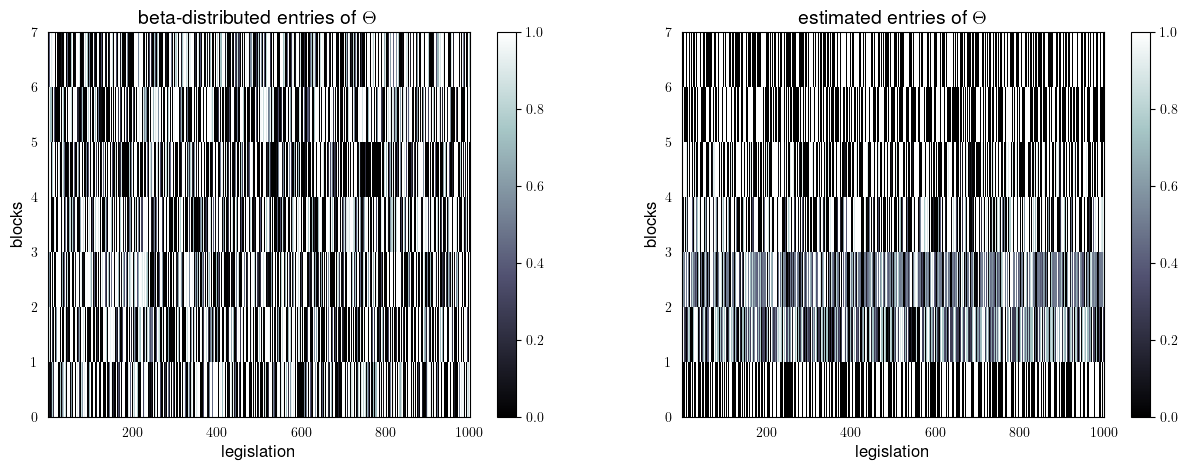

In [95]:
# figure 6 (gray-coded representation)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=15, 5
fig = plt.figure()

ax = fig.add_subplot(121)

heatmap = ax.pcolor(Theta, cmap="bone")
ax.set_xticks(np.arange(200, 1200, 200))
plt.tick_params(left = False)
plt.tick_params(bottom = False)
ax.set_xlabel("legislation", fontsize=12)
ax.set_ylabel("blocks", fontsize=12)
ax.set_title("beta-distributed entries of $\Theta$", fontsize=14)

plt.colorbar(heatmap)


ax = fig.add_subplot(122)

heatmap = ax.pcolor(Theta_hat, cmap="bone")
ax.set_xticks(np.arange(200, 1200, 200))
plt.tick_params(left = False)
plt.tick_params(bottom = False)
ax.set_xlabel("legislation", fontsize=12)
ax.set_ylabel("blocks", fontsize=12)
ax.set_title("estimated entries of $\Theta$", fontsize=14)

plt.colorbar(heatmap)

plt.show()

**Figure 36.6** ($\textit{Left}$) A gray-coded representation of the values of the probabilities $\{\theta_{b,\ell}\}$ generated independently according to beta $(0.1,0.1)$. ($\textit{Right}$) A similar diagram using the estimated values $\{\widehat{\theta}_{b,\ell}\}$ at the end of recursion (36.157).

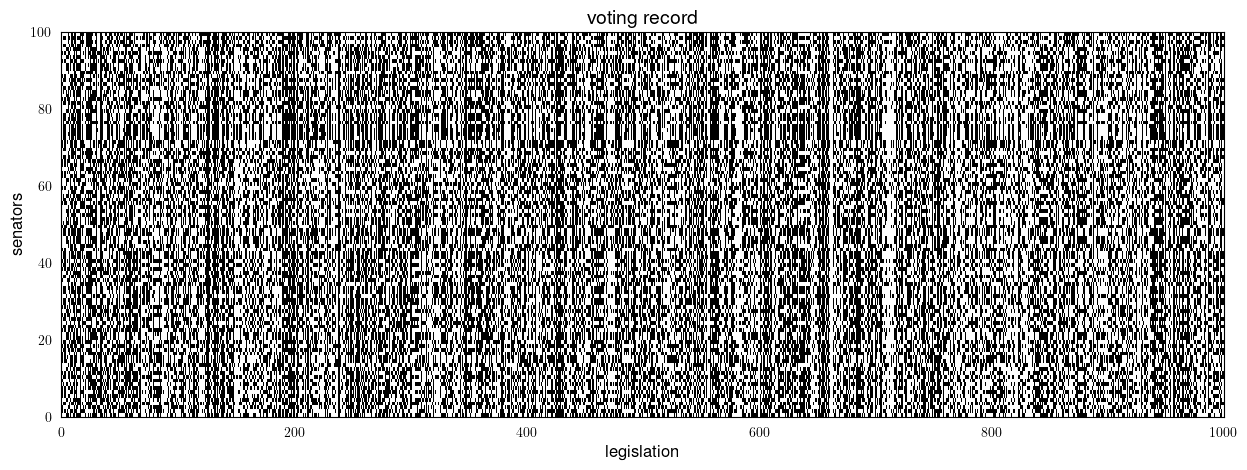

In [96]:
#figure 7 (voting record)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=15, 5
fig = plt.figure()

ax = fig.add_subplot(111)

heatmap = ax.pcolor(V, cmap="bone")
plt.tick_params(left = False)
plt.tick_params(bottom = False)
ax.set_xlabel("legislation", fontsize=12)
ax.set_ylabel("senators", fontsize=12)
ax.set_title("voting record", fontsize=14)

plt.show()

**Figure 36.7** A diagram representing the votes by the senators on the various legislative issues posed to them. A dark color corresponds to an affirmative vote ($v_{n,\ell}=1$), while a light color corresponds to a negative vote ($v_{n,\ell}=0$).

We apply recursions (36.155) for $100$ iterations. Using (36.156a)--(36.156d), and the estimated values at the end of these $100$ iterations, we find 

$$
\begin{align*}
(\widehat{\lambda}_1,\widehat{\lambda}_2) & =(7.3337, 7.1520) \tag{36.165} \\ 
\widehat{\pi} & =\begin{bmatrix}
0.5600&    0.0000 &   0.0000  &  0.0000 &   0.2800    0.0000   & 0.1600
\end{bmatrix}^{\sf T} \tag{36.166} \\
\widehat{\alpha} & =\begin{bmatrix}
64.1079&8.0130&9.7175&6.7358&28.4260&9.5652&20.8754
\end{bmatrix} \tag{36.167}
\end{align*}
$$

The simulation ends up identifying four blocks of senators with $(30,12,20,38)$ members, respectively. The blocks are shown in the left plot in the top row of Fig. 36.8, where the senators are renumbered and grouped together into four blocks indicated by the  squares. Senators within the same block tend to vote together. To generate this figure, we renumber the senators so that those belonging to the same group are renumbered sequentially. 
The right plot in the top row maintains the original numbering of the senators along the horizontal axis, and colors their block assignments. For example, the senator with original number $\#45$ is assigned to block $6$).  The same information appears in the left plot in the bottom row, while the right plot in that row shows the new numbering of the senators against their original numbers  (for example, the senator with original number $\#45$ is now assigned number  $20$). 

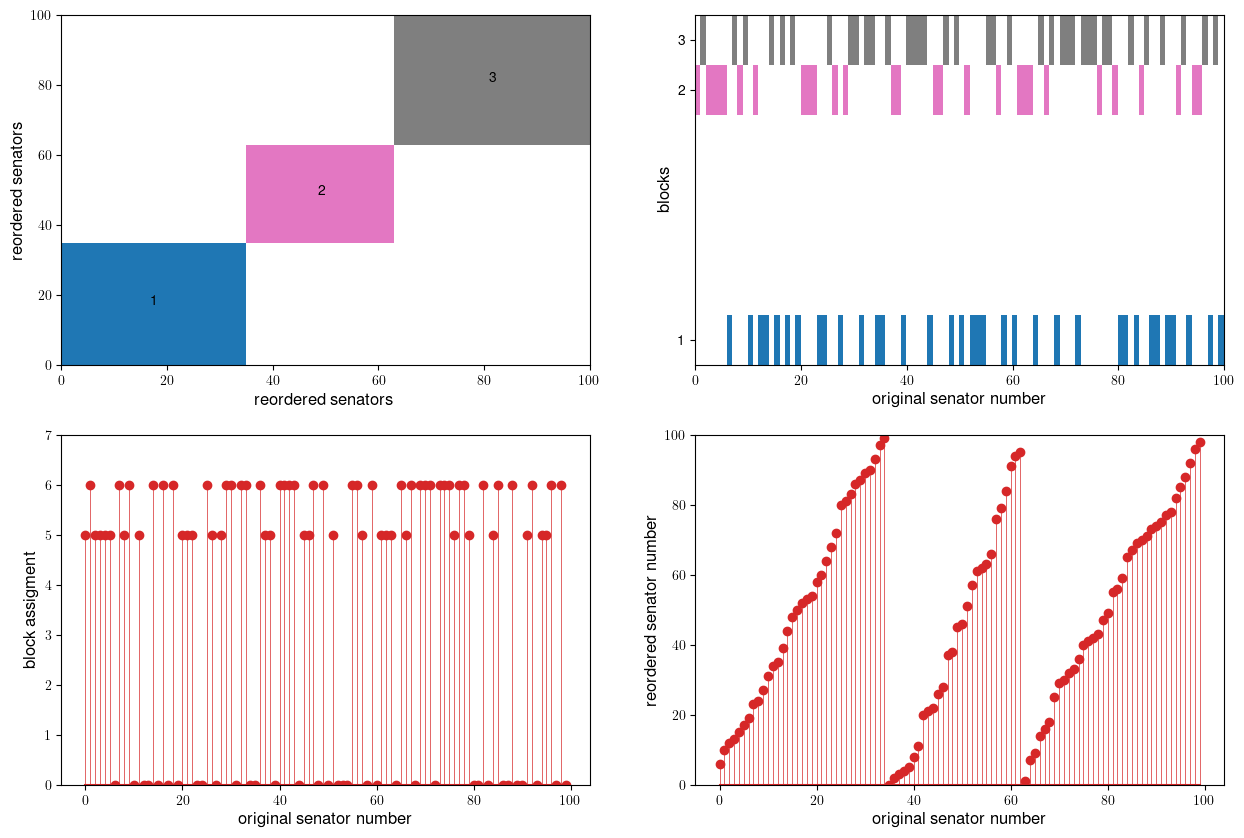

In [97]:
#figure 8  (reordered senators)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=15, 10
fig = plt.figure()

ax = fig.add_subplot(221)

cMap = c.ListedColormap(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "w"])

ax.pcolor(groups, cmap=cMap)
ax.set_xlabel("reordered senators", fontsize=12)
ax.set_ylabel("reordered senators", fontsize=12)

n_groups = np.delete(np.unique(groups), -1) # remove the white color (background)

for i, group in enumerate(n_groups):
    group_min = np.argwhere(groups == group).min()
    group_max = np.argwhere(groups == group).max()

    ax.annotate(f"{i+1}", xy=((group_max+group_min)/2, (group_max+group_min)/2))

ax = fig.add_subplot(222)

group_h = []
for group in n_groups:
    group_h.append(np.argwhere(unordered_groups == group)[0, 0])

labels = []
ticks = []
g = 1
for i in range(unordered_groups.shape[0]):
    if i in group_h:
        labels.append(str(g))
        ticks.append(i+0.5)
        g += 1

ax.pcolor(unordered_groups, cmap=cMap)
ax.set_xlabel("original senator number", fontsize=12)
ax.set_ylabel("blocks", fontsize=12)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

ax = fig.add_subplot(223)

markerline, stemlines, baseline = ax.stem(np.arange(N), estimated_b_vec)
plt.setp(stemlines, 'color', 'tab:red')
plt.setp(stemlines, 'linewidth', 0.5)
plt.setp(markerline, 'color', 'tab:red')
ax.set_xlabel("original senator number", fontsize=12)
ax.set_ylabel("block assigment", fontsize=12)
ax.set_ylim([0, 7])

ax = fig.add_subplot(224)

markerline, stemlines, baseline = ax.stem(np.arange(N), indexes)
plt.setp(stemlines, 'color', 'tab:red')
plt.setp(stemlines, 'linewidth', 0.5)
plt.setp(markerline, 'color', 'tab:red')
ax.set_xlabel("original senator number", fontsize=12)
ax.set_ylabel("reordered senator number", fontsize=12)
ax.set_ylim([0, N])

plt.savefig("figs/fig-8.pdf", format="pdf", bbox_inches="tight")

plt.show()

**Figure 36.8** ($\textit{Top left}$) Senators are renumbered and grouped together into four blocks indicated by the colored squares. Senators within the same block tend to vote together. ($\textit{Top right}$) Original numbering for senators is shown on the horizontal axis with their block assignments across the vertical axis. ($\textit{Bottom left}$) Similar information in graphical form showing the block assignments using the original numbering for the senators. ($\textit{Bottom right}$) Mapping from original numbers to reordered numbers. 

## Example 36.13 (Estimating the posterior for probit models)

Let us reconsider the probit model from Example 36.4, which consisted of the following generative model:

$$
\left\{ \begin{array}{ll}
        \textnormal{generate } w\sim{\cal N}_{w}(0,\sigma_{w}^2 I_M) \\
        \textbf{for } \textnormal{each data point } n = 1, 2, ..., N \\
        \left\{ \begin{array}{ll}
                \textnormal{generate } z_n \sim{\cal N}_{z_n}(h_n^{\sf T}w, 1) \\
                \textnormal{set } \gamma(n) = +1 \textnormal{ if } z_n > 0 \textnormal{; otherwise, } \gamma(n) = -1
        \end{array} \right. \\
        \textbf{end}
\end{array} \right. \tag{36.271}
$$

 We therefore have a model with one global latent variable, $w$, and $N$ local latent variables $\{z_n\}$. We collect all these variables into:

$$
z\overset{\Delta}{=} \begin{bmatrix} w\\ z_1\\ \vdots\\ z_N \end{bmatrix} \tag{36.272}
$$

We know that the joint pdf is given by (we are indicating the variance of $z_n$ explicitly by writing $\sigma_n^2$ although we know from (36.271) that it is equal to 1):

$$
\begin{align*}
f_{\gamma,z}(y,z) &=
f_{w}(w)\left(\prod_{n=1}^N f_{z|w}(z_n|w)\,f_{\gamma|z,w}(\gamma_n|z_n,w)\right)\\ &
=\frac{1}{\sqrt{2\pi\sigma_{w}^2}}e^{-\frac{1}{2\sigma_{w}^2}\|w\|^2}\times
\left(\prod_{n=1}^N \frac{1}{\sqrt{2\pi\sigma_n^2}}e^{-\frac{1}{2\sigma_n^2}(z_n-h_n^{\sf T} w)^2}\right)\times \\ &
\left(\prod_{n=1}^N \left(\frac{1+\gamma(n)}{2}\right)^{\mathbb{I}[z_n>0]}
\left(\frac{1-\gamma(n)}{2}\right)^{\mathbb{I}[z_n\leq 0]}\right)
\end{align*} \tag{36.273}
$$

so that 

$$
\begin{align*} &
\ln f_{\gamma,z}(y,z)\\ &
=-\frac{1}{2}\ln(2\pi\sigma_w^2)-\frac{1}{2\sigma_w^2}\|w\|^2-\frac{1}{2}
\sum_{n=1}^N\ln(2\pi\sigma_n^2)-\frac{1}{2}\sum_{n=1}^N (z_n-h_nw)^2+\\ &
\;\;\;\;\;\;\sum_{n=1}^N \mathbb{I}[z_n>0] \ln\left(\frac{1+\gamma(n)}{2}\right)+
\mathbb{I}[z_n\leq 0]\ln\left(\frac{1-\gamma(n)}{2}\right)
\end{align*} \tag{36.274}
$$

We next assume a Gaussian distribution for each entry of the latent vector $z$ with means and variances (these are approximations for the conditional distributions of $w$ and $z_n$, conditioned on all observations $\{h_n,\gamma(n)\}$):

$$
\begin{align*} &
w\sim{\cal N}_{w}(\bar{w}, \widehat{\sigma}_{w}^2 I_M) \tag{36.275} \\ &
z_n\sim{\cal N}_{z_n}(\bar{z}_n, \widehat{\sigma}_{n}^2) \tag{36.276}
\end{align*}
$$

so that the entries of the parameter vector $\zeta$ are

$$
\zeta\overset{\Delta}{=} \Bigl\{\bar{w},\widehat{\sigma}_{w}^2, \bar{z}_1,\widehat{\sigma}_1^2,\ldots, 
\bar{z}_N,\widehat{\sigma}_N^2
\Bigr\} \tag{36.277}
$$

and the variational distribution is given by

$$
q_{z}(z;\zeta)=\frac{1}{\sqrt{2\pi\widehat{\sigma}_w^2}}e^{-\frac{1}{2\widehat{\sigma}_w^2}\|w-\bar{w}\|^2}\times \left(\prod_{n=1}^N \frac{1}{\sqrt{2\pi \widehat{\sigma}_n^2}}e^{-\frac{1}{2\widehat{\sigma}_n^2}(z_n-\bar{z}_n)^2}\right) \tag{36.278}
$$

It follows that

$$
\begin{align*} &
\ln q_{z}(z;\zeta)\\ &
=-\frac{1}{2}\ln(2\pi \widehat{\sigma}_w^2)-
\frac{1}{2\widehat{\sigma}_w^2}\|w-\bar{w}\|^2-\frac{1}{2}\sum_{n=1}^N 
\ln(2\pi \widehat{\sigma}_n^2)-\frac{1}{2}\sum_{n=1}^N\frac{1}{\widehat{\sigma}_n^2}(z_n-\bar{z}_n)^2
\end{align*} \tag{36.279}
$$

Differentiating this expression relative to the means and variances we get:

$$
\begin{align*} &
\nabla_{\bar{w}^{\sf T}}\ln q_{z}(z;\zeta)=\frac{1}{\widehat{\sigma}_w^2}(w-\bar{w}) \tag{36.280a} \\ &
\partial \ln q_{z}(z;\zeta)/\partial _{\widehat{\sigma}_w^2}=-\frac{1}{2\widehat{\sigma}^2_w}+\frac{1}{2\widehat{\sigma}_w^4}
\|w-\bar{w}\|^2 \tag{36.280b} \\ &
\partial\ln q_{z}(z;\zeta)/\partial _{\bar{z}_n} =\frac{1}{\widehat{\sigma}^2_n}(z_n-\bar{z}_n) \tag{36.280c} \\ &
\partial \ln q_{z}(z;\zeta)/\partial _{\widehat{\sigma}_n^2}=-\frac{1}{2\widehat{\sigma}^2_n}+\frac{1}{2\widehat{\sigma}_n^4}
(z_n-\bar{z}_n)^2 \tag{36.280d}
\end{align*}
$$

By concatenating these values we obtain the gradient vector of $\ln q_{z}(z;\zeta)$ relative to $\zeta$. We therefore have all the elements necessary to run recursions (36.270).

$$
\left\{ \begin{array}{ll}
        \textbf{Stochastic variational inference for probit model (36.271).} \\ \\
        \textbf{given} \textnormal{: features and labels } \{h_n,\gamma(n)\}, n=1,2,\ldots,N; \\ \\
        \textbf{start with: } \Bigl\{\bar{w}^{(-1)}, \widehat{\sigma}_{w}^{2, (-1)}, \bar{z}_n^{(-1)}, \widehat{\sigma}_n^{2, (-1)}\Bigr\},\, n=1,2,\ldots,N \\ \\
        \textbf{repeat over } m = 0, 1, 2, ... \\ \\
        \left\{ \begin{array}{ll}
                \textnormal{generate B samples } w_b\sim {\cal N}\Bigl(\bar{w}^{(m-1)}, \widehat{\sigma}_{w}^{2, (m-1)}I_M\Bigr) \\
                \textnormal{for each n, generate B samples } z_{n,b}\sim {\cal N}\Bigl(\bar{z}_n^{(m-1)}, \widehat{\sigma}_{n}^{2, (m-1)}\Bigr) \\
                \textnormal{collect the samples into B vectors } z_b=\textnormal{col}\{w_b, z_{1,b}, z_{2,b},\ldots, z_{N,b}\} \\
                {\delta}^{(m)}\overset{\Delta}{=} \dfrac{1}{B}\displaystyle \sum_{b=1}^B 
                \Bigl(\nabla_{\zeta^{\sf T}}\ln q_{z}(z_{b};\zeta^{(m-1)})\Bigr)\Bigl[\ln f_{\gamma,z}(\gamma,z_{b})-\ln q_{z}(z_{b};\zeta^{(m-1)})\Bigr] \\
                \zeta^{(m)}=\zeta^{(m-1)}+D_m \delta^{(m)} \\
        \end{array} \right. \\
        \textbf{end} \\ \\
\end{array} \right. \tag{36.281}
$$

The term $\ln f_{\gamma,z}(\gamma,z_b)$ in the expression for $\delta^{(m)}$ in the above algorithm is evaluated by substituting $(w,z_n)$ in (36.274) by $(w_b,z_{n,b})$. We obtain better performance in this case if we also replace $(\sigma_w^2,\sigma_n^2)$ in the expression for $f_{\gamma,z}(\gamma,z_b)$ by $(\widehat{\sigma}_w^2, \widehat{\sigma}_n^2)$, which estimate the conditional variances of the latent variables. Once the variational factors are estimated, we can use expression 
(36.118), with $R_w$ replaced by $\widehat{\sigma}_w^2 I_M$, to perform prediction, namely, 

$$
\mathbb{P}(\gamma=\gamma|\gamma_N= \gamma_N; h,H_N)\approx 
\Phi\left(\frac{\gamma h^{\sf T} \bar{w}}{\sqrt{1+\widehat{\sigma}_w^2 \|h\|^2}}\right) \tag{36.282}
$$

We illustrate this construction by means of a simulation. A total of $N=400$ feature vectors $\{h_n\in\mathbb{R}^{2}\}$ are generated randomly from a Gaussian distribution with zero mean and unit variance. The weight vector $w\in\mathbb{R}^{2}$ is also generated randomly from a Gaussian distribution with zero mean and variance $\sigma_{w}^2=2$. For each $h_n$, we assign its label to $\gamma(n)=+1$ with probability equal to $\Phi(h_n^{\sf T} w)$; otherwise, it is assigned to $\gamma(n)=-1$. 
The $400$ pairs $\{h_n,\gamma(n)\}$ generated in this manner are used for training. These samples are shown in the top row of Fig. 36.9. We also generate separately $50$ additional sample pairs $\{h_n,\gamma(n)\}$ to be used during testing. These samples are shown in the plot on the left in the bottom row. We run recursions (36.281) for $200,000$ iterations using a small step size 
$D_m={10^{-8}\over m+1} I$. The algorithm leads to

$$
\bar{w}=\begin{bmatrix}-0.9091\\0.2560 \end{bmatrix},\;\;\;\;\widehat{\sigma}_w^2=0.7047 \tag{36.283}
$$

Using these values, we predict the label for each of the test features $h_n$ using construction (36.282), namely, we assign $h_n$ to class $\gamma(n)=+1$ if

$$
\Phi\left(\frac{h^{\sf T} \bar{w}}{\sqrt{1+\widehat{\sigma}_{w}^2\|h\|^2}}\right)\geq 1/2 
\Longrightarrow\;\gamma(n)=+1 \tag{36.284}
$$

The result is shown in the plot on the right in the bottom row of Fig. 36.9 with an error rate of $16\%$ (meaning that eight test samples are misclassified).

In [ ]:
w = w_model
epsilon = 0.000001

B = 10 # batch size
w_bar_svi = np.random.randn(M) # initial conditions
sigma_w_svi = np.random.rand() + epsilon
z_bar_svi = np.random.randn(N)
sigma_z_svi = np.random.rand(N) + epsilon
L = 1000 # reapeat for this many iterations

for m in range(L):
  W = np.zeros((M,B))
  Z = np.zeros((N,B))
  for b in range(B): # generate B random samples
      W[:,b] = np.sqrt(sigma_w_svi)*np.random.randn(M)
      W[:, b] = W[:,b] + w_bar_svi

  for n in range(N): # for each n, generate B random samples
    for b in range(B):
      Z[n, b] = np.sqrt(sigma_z_svi[n])*np.random.randn()
      Z[n, b] = Z[n, b] + z_bar_svi[n]
  
  sum_batch = 0
  
  for b in range(B):
    wb = W[:, b]
    zb = Z[:, b]
    lnq = 0
    lnq = lnq - 0.5*np.log(2*np.pi*sigma_w_svi)
    lnq = lnq - (0.5/sigma_w_svi)*(np.linalg.norm(wb-w_bar_svi)**2)
   
    for n in range(N):
      lnq = lnq - 0.5*np.log(2*np.pi*sigma_z_svi[n]) - (0.5/sigma_z_svi[n])*((zb[n]-z_bar_svi[n])**2)
    
    gradq = (1/sigma_w_svi)*(wb-w_bar_svi)
    gradq = np.append(gradq, -((0.5/sigma_w_svi))+(0.5/(sigma_w_svi**2))*(np.linalg.norm(wb-w_bar_svi)**2))  
    
    for n in range(N):
       gradq = np.append(gradq, (1/sigma_z_svi[n])*(zb[n]-z_bar_svi[n]))
       gradq = np.append(gradq, (0.5/(sigma_z_svi[n]**2))*(zb[n]-z_bar_svi[n]**2))
            
    lnf = 0
    lnf = lnf - 0.5*np.log(2*np.pi*sigma_w_svi)
    lnf = lnf - (0.5/sigma_w_svi)*(np.linalg.norm(wb)**2)
  
    for n in range(N):
       lnf = lnf - 0.5*np.log(2*np.pi*sigma_z_svi[n])
       h = H[:,n]
       lnf = lnf -0.5*((zb[n] - h.T@wb)**2)
       if zb[n] > 0:
          lnf = lnf + np.log(0.5*(1+gamma_vec[n])+epsilon) # added epsilon to avoid log0
       else:
          lnf = lnf + np.log(0.5*(1-gamma_vec[n])+epsilon)
    sum_batch = sum_batch + gradq*(lnf - lnq)

  delta = sum_batch/B
  step_size_1 = 0.00000001/(m+1); #step-size for means set to a constant value
  step_size_2 = 0.00000001/(m+1); #step-size for variances
  
  w_bar_svi   = w_bar_svi   + step_size_1*delta[:M]
  sigma_w_svi = sigma_w_svi + step_size_2*delta[M]
  if sigma_w_svi < 0:
      sigma_w_svi = epsilon # to avoid working with negative variances (type of projection)
  
  delta2 = delta[M+1:2*N +M+1]
  for n in range(N):
    z_bar_svi[n]   = z_bar_svi[n]   + step_size_1*delta2[2*n-1]
    sigma_z_svi[n] = sigma_z_svi[n] + step_size_2*delta2[2*n]
    if sigma_z_svi[n] <0:
        sigma_z_svi[n] = epsilon


n1 = 0
n2 = 0
error_test = 0

A1_after_testing = np.zeros(A1.shape)
A2_after_testing = np.zeros(A2.shape)
G1_after_testing = np.zeros(G1.shape)
G2_after_testing = np.zeros(G2.shape)

for n in range(NT): # testing
    h = Htest[:, n]
    a = h.T@wbar
    b = 1 + h.T@Rw@h
    b = np.sqrt(b)
    d = norm.cdf(a/b)
    if d >= 1/2:
        A1_after_testing[n1, :] = h.T
        G1_after_testing[n1] = 1
        n1 += 1
        if gammatest[n] != 1:
           error_test += 1
    else:
        A2_after_testing[n2, :] = h.T
        G2_after_testing[n2] = 1
        n2 += 1
        if gammatest[n] != -1:
           error_test += 1

A1_after_testing = A1_after_testing[:n1]
A2_after_testing = A2_after_testing[:n2]
G1_after_testing = G1_after_testing[:n1]
G2_after_testing = G2_after_testing[:n2]  

Mean o w from coordinate ascent and from stochastic variational inference:
[0.79127696 1.80621334] [ 2.36326621 -0.67134861]
Tr(Rw) from coordinate ascent and sigma_w^2 from stochastic variational inference:
0.005309315691185528 0.9322331950855509
Error rate:  26.0


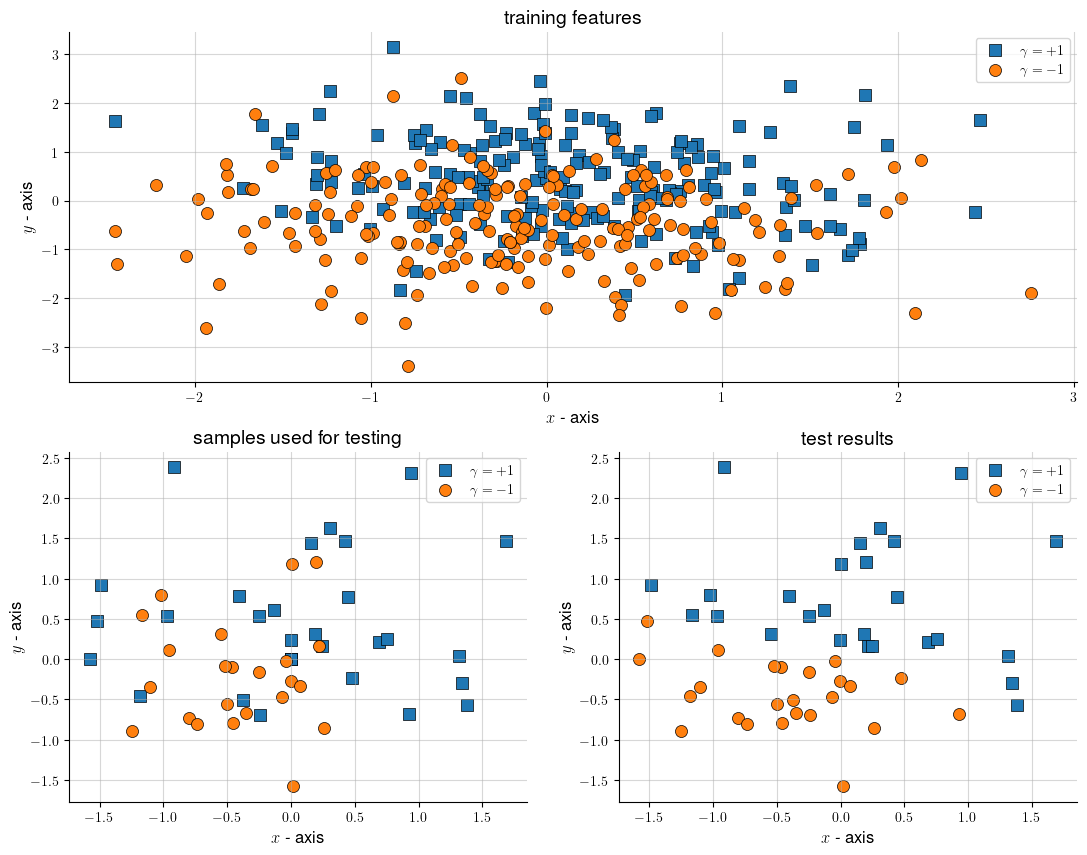

In [49]:
print("Mean o w from coordinate ascent and from stochastic variational inference:")
print(wbar, w_bar_svi)
print("Tr(Rw) from coordinate ascent and sigma_w^2 from stochastic variational inference:")
print(np.trace(Rw), sigma_w_svi)

print("Error rate: ", (error_test/NT)*100)

# figure 9 (scatter diagrams)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13,10
fig = plt.figure()

ax = fig.add_subplot(2, 2, (1, 2))

ax.scatter(A1[:, 0], A1[:, 1], marker="s", s=75, edgecolors="black", linewidths=0.5, label="$\gamma = +1$")
ax.scatter(A2[:, 0], A2[:, 1], s=75, edgecolors="black", linewidths=0.5, label="$\gamma = -1$")
ax.set_xlabel("$x$ - axis", fontsize=12)
ax.set_ylabel("$y$ - axis", fontsize=12)
ax.set_title("training features", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()


ax = fig.add_subplot(2, 2, 3)

ax.scatter(A1_test[:, 0], A1_test[:, 1], marker="s", s=75, edgecolors="black", linewidths=0.5, label="$\gamma = +1$")
ax.scatter(A2_test[:, 0], A2_test[:, 1], s=75, edgecolors="black", linewidths=0.5, label="$\gamma = -1$")
ax.set_xlabel("$x$ - axis", fontsize=12)
ax.set_ylabel("$y$ - axis", fontsize=12)
ax.set_title("samples used for testing", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

ax = fig.add_subplot(2, 2, 4)

ax.scatter(A1_after_testing[:, 0], A1_after_testing[:, 1], marker="s", s=75, edgecolors="black", linewidths=0.5, label="$\gamma = +1$")
ax.scatter(A2_after_testing[:, 0], A2_after_testing[:, 1], s=75, edgecolors="black", linewidths=0.5, label="$\gamma = -1$")
ax.set_xlabel("$x$ - axis", fontsize=12)
ax.set_ylabel("$y$ - axis", fontsize=12)
ax.set_title("test results", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

plt.savefig("figs/fig-5.pdf", format="pdf", bbox_inches="tight")

plt.show()

**Figure 36.9** ($\textit{Top row}$) A total of $N=400$ pairs $\{h_n,\gamma(n)\}$ used for training in order to learn the predictive distribution (36.282). ($\textit{Bottom row}$) The plot on the left shows the $50$ pairs $\{h_n,\gamma(n)\}$ used for testing. The plot on the right shows the labels that are assigned by the test (36.284) to these points. 